In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
import sys

# Add src directory to Python path to import our custom module
# This assumes your notebook is in 'notebooks/' and 'src/' is a sibling directory
# Adjust if your notebook location or project structure is different
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) # Navigates up from 'notebooks' to project root
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Import our data loading function
from data_processing.load_walmart_data import load_and_merge_walmart_data

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style that's generally available
plt.rcParams['figure.figsize'] = (15, 7)
pd.set_option('display.max_columns', None) # Show all columns in DataFrames

In [2]:
# Load the merged Walmart data using our function
# The load_and_merge_walmart_data function uses a relative path from its own location
# to find the data/raw directory.
# If running this notebook from the 'notebooks' directory, the default pathing in
# load_walmart_data.py should correctly find 'project_root/data/raw/'
df = load_and_merge_walmart_data()

if df is not None:
    print("Data loaded successfully!")
    print(f"Shape of the merged DataFrame: {df.shape}")
else:
    print("Data loading failed. Please check the path and file names in 'src/data_processing/load_walmart_data.py' and ensure data files are in 'data/raw/'.")

--- Attempting to load data from: /Users/ramesh/Desktop/supply_chain_ai_platform/data/raw ---
Loading train.csv...
Loaded train.csv with shape: (421570, 5)
Loading features.csv...
Loaded features.csv with shape: (8190, 12)
Loading stores.csv...
Loaded stores.csv with shape: (45, 3)

--- Merging DataFrames ---
Shape after merging train and stores: (421570, 7)
Shape after merging with features: (421570, 16)

--- Performing Initial Cleaning & Transformations ---
Converted 'Date' to datetime and sorted DataFrame.

--- Successfully loaded and merged data. Final DataFrame shape: (421570, 16) ---
Data loaded successfully!
Shape of the merged DataFrame: (421570, 16)


In [3]:
if df is not None:
    print("--- First 5 Rows ---")
    display(df.head()) # 'display()' is often better in notebooks than print() for DataFrames

    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- Descriptive Statistics (Numerical Features) ---")
    display(df.describe())

    print("\n--- Missing Values (Sum) ---")
    missing_values_sum = df.isnull().sum()
    display(missing_values_sum[missing_values_sum > 0].sort_values(ascending=False))

    print("\n--- Missing Values (Percentage) ---")
    missing_values_percent = (df.isnull().sum() / len(df) * 100)
    display(missing_values_percent[missing_values_percent > 0].sort_values(ascending=False))

--- First 5 Rows ---


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64      

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000
std,12.785297,30.492054,NaN,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296



--- Missing Values (Sum) ---


MarkDown2    310322
MarkDown4    286603
MarkDown3    284479
MarkDown1    270889
MarkDown5    270138
dtype: int64


--- Missing Values (Percentage) ---


MarkDown2    73.611025
MarkDown4    67.984676
MarkDown3    67.480845
MarkDown1    64.257181
MarkDown5    64.079038
dtype: float64

In [4]:
def handle_markdown_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handles missing values in MarkDown columns.
    Assumes NaN in MarkDown columns means no markdown was applied, so fills with 0.

    Args:
        df (pd.DataFrame): DataFrame with MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5 columns.

    Returns:
        pd.DataFrame: DataFrame with NaNs in MarkDown columns filled with 0.
    """
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
            print(f"Filled NaNs in '{col}' with 0.")
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df

def handle_cpi_unemployment_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handles missing values in CPI and Unemployment columns using forward fill
    grouped by Store, as these values are likely to be consistent for a store
    over short periods or change slowly.

    Args:
        df (pd.DataFrame): DataFrame with CPI and Unemployment columns, and a 'Store' column.
                           The DataFrame should be sorted by 'Store' and 'Date'
                           for forward fill to work as expected.

    Returns:
        pd.DataFrame: DataFrame with NaNs in CPI and Unemployment filled.
    """
    # Ensure data is sorted for forward fill to make sense within each group
    df_sorted = df.sort_values(by=['Store', 'Date'])
    
    if 'CPI' in df_sorted.columns:
        print("Handling missing values for 'CPI' using forward fill per Store...")
        df_sorted['CPI'] = df_sorted.groupby('Store')['CPI'].ffill()
        # For any remaining NaNs (e.g., at the very beginning of a store's history),
        # we can use a backward fill or fill with the overall mean/median.
        # Let's try backward fill first within the group.
        df_sorted['CPI'] = df_sorted.groupby('Store')['CPI'].bfill()
        # If still NaNs (e.g. a store has ALL NaNs for CPI), fill with overall median
        if df_sorted['CPI'].isnull().any():
            overall_median_cpi = df_sorted['CPI'].median()
            df_sorted['CPI'] = df_sorted['CPI'].fillna(overall_median_cpi)
            print(f"Filled remaining NaNs in 'CPI' with overall median: {overall_median_cpi}")
    else:
        print("Warning: Column 'CPI' not found.")

    if 'Unemployment' in df_sorted.columns:
        print("Handling missing values for 'Unemployment' using forward fill per Store...")
        df_sorted['Unemployment'] = df_sorted.groupby('Store')['Unemployment'].ffill()
        df_sorted['Unemployment'] = df_sorted.groupby('Store')['Unemployment'].bfill()
        if df_sorted['Unemployment'].isnull().any():
            overall_median_unemployment = df_sorted['Unemployment'].median()
            df_sorted['Unemployment'] = df_sorted['Unemployment'].fillna(overall_median_unemployment)
            print(f"Filled remaining NaNs in 'Unemployment' with overall median: {overall_median_unemployment}")
    else:
        print("Warning: Column 'Unemployment' not found.")
        
    return df_sorted

In [5]:
if df is not None:
    print("\n--- Handling Missing Values ---")
    # Apply markdown missing value handling
    df = handle_markdown_missing_values(df.copy()) # Use .copy() to avoid SettingWithCopyWarning on slices

    # Apply CPI and Unemployment missing value handling
    df = handle_cpi_unemployment_missing_values(df.copy())

    print("\n--- Missing Values After Handling (Sum) ---")
    missing_values_sum_after = df.isnull().sum()
    display(missing_values_sum_after[missing_values_sum_after > 0].sort_values(ascending=False))

    print("\n--- Missing Values After Handling (Percentage) ---")
    missing_values_percent_after = (df.isnull().sum() / len(df) * 100)
    display(missing_values_percent_after[missing_values_percent_after > 0].sort_values(ascending=False))

    # Re-check info to see data types and non-null counts
    print("\n--- DataFrame Info After Handling Missing Values ---")
    df.info()
else:
    print("DataFrame 'df' is None. Skipping missing value handling.")


--- Handling Missing Values ---
Filled NaNs in 'MarkDown1' with 0.
Filled NaNs in 'MarkDown2' with 0.
Filled NaNs in 'MarkDown3' with 0.
Filled NaNs in 'MarkDown4' with 0.
Filled NaNs in 'MarkDown5' with 0.
Handling missing values for 'CPI' using forward fill per Store...
Handling missing values for 'Unemployment' using forward fill per Store...

--- Missing Values After Handling (Sum) ---


Series([], dtype: int64)


--- Missing Values After Handling (Percentage) ---


Series([], dtype: float64)


--- DataFrame Info After Handling Missing Values ---
<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     421570 non-null  float64       
 10  MarkDown2     421570 non-null  float64       
 11  MarkDown3     421570 non-null  float64       
 12  MarkDown4     421570 non-null  float64       
 13  MarkDown5     421570 non-null  float64       
 14  CPI           42157


--- Target Variable Analysis: Weekly_Sales ---


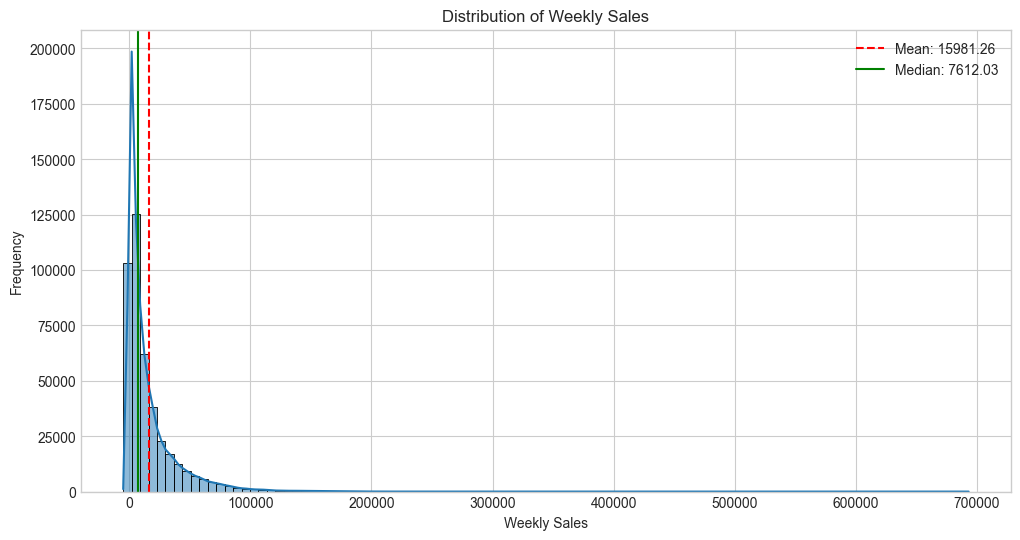

Skewness of Weekly_Sales: 3.26
Kurtosis of Weekly_Sales: 21.49


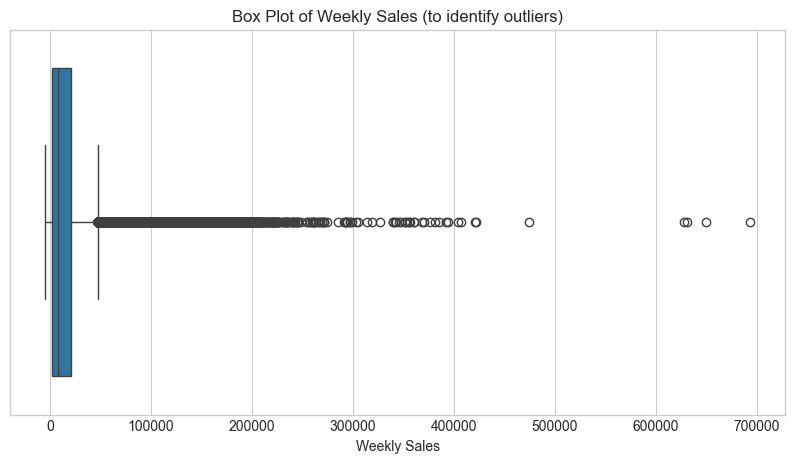


Number of instances with negative Weekly_Sales: 1285
Percentage of data with negative Weekly_Sales: 0.30%


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
6048,1,47,2010-02-19,-863.0,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
6049,1,47,2010-03-12,-698.0,False,A,151315,57.79,2.667,0.0,0.0,0.0,0.0,0.0,211.380643,8.106
6051,1,47,2010-10-08,-58.0,False,A,151315,63.93,2.633,0.0,0.0,0.0,0.0,0.0,211.746754,7.838
6562,1,54,2011-01-21,-50.0,False,A,151315,44.04,3.016,0.0,0.0,0.0,0.0,0.0,211.827234,7.742
6056,1,47,2011-04-08,-298.0,False,A,151315,67.84,3.622,0.0,0.0,0.0,0.0,0.0,215.074394,7.682


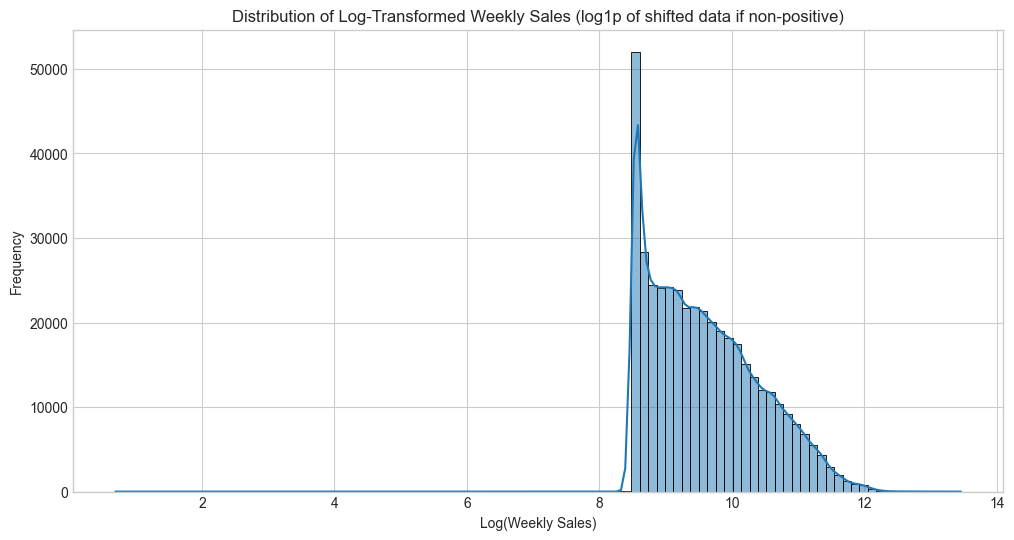

Skewness of log-transformed Weekly_Sales: 0.61


In [ ]:
if df is not None:
    print("\n--- Target Variable Analysis: Weekly_Sales ---")

    # 1. Distribution of Weekly_Sales
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Weekly_Sales'], kde=True, bins=100)
    plt.title('Distribution of Weekly Sales')
    plt.xlabel('Weekly Sales')
    plt.ylabel('Frequency')
    plt.axvline(df['Weekly_Sales'].mean(), color='r', linestyle='--', label=f"Mean: {df['Weekly_Sales'].mean():.2f}")
    plt.axvline(df['Weekly_Sales'].median(), color='g', linestyle='-', label=f"Median: {df['Weekly_Sales'].median():.2f}")
    plt.legend()
    plt.show()
    print(f"Skewness of Weekly_Sales: {df['Weekly_Sales'].skew():.2f}")
    print(f"Kurtosis of Weekly_Sales: {df['Weekly_Sales'].kurtosis():.2f}")

    # 2. Box Plot for Outliers
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['Weekly_Sales'])
    plt.title('Box Plot of Weekly Sales (to identify outliers)')
    plt.xlabel('Weekly Sales')
    plt.show()

    # 3. Investigate Negative Sales Values
    negative_sales = df[df['Weekly_Sales'] < 0]
    print(f"\nNumber of instances with negative Weekly_Sales: {len(negative_sales)}")
    if not negative_sales.empty:
        print(f"Percentage of data with negative Weekly_Sales: {(len(negative_sales)/len(df)*100):.2f}%")
        display(negative_sales.head())
        
    min_sales = df['Weekly_Sales'].min()
    if min_sales <= 0:
        sales_for_log = df['Weekly_Sales'] - min_sales + 1 # Shift to make all positive
    else:
        sales_for_log = df['Weekly_Sales']

    plt.figure(figsize=(12, 6))
    sns.histplot(np.log1p(sales_for_log), kde=True, bins=100) # log1p handles x=0 by computing log(1+x)
    plt.title('Distribution of Log-Transformed Weekly Sales (log1p of shifted data if non-positive)')
    plt.xlabel('Log(Weekly Sales)')
    plt.ylabel('Frequency')
    plt.show()
    print(f"Skewness of log-transformed Weekly_Sales: {np.log1p(sales_for_log).skew():.2f}")

else:
    print("DataFrame 'df' is None. Skipping Target Variable Analysis.")


--- Univariate Analysis of Key Numerical Features ---


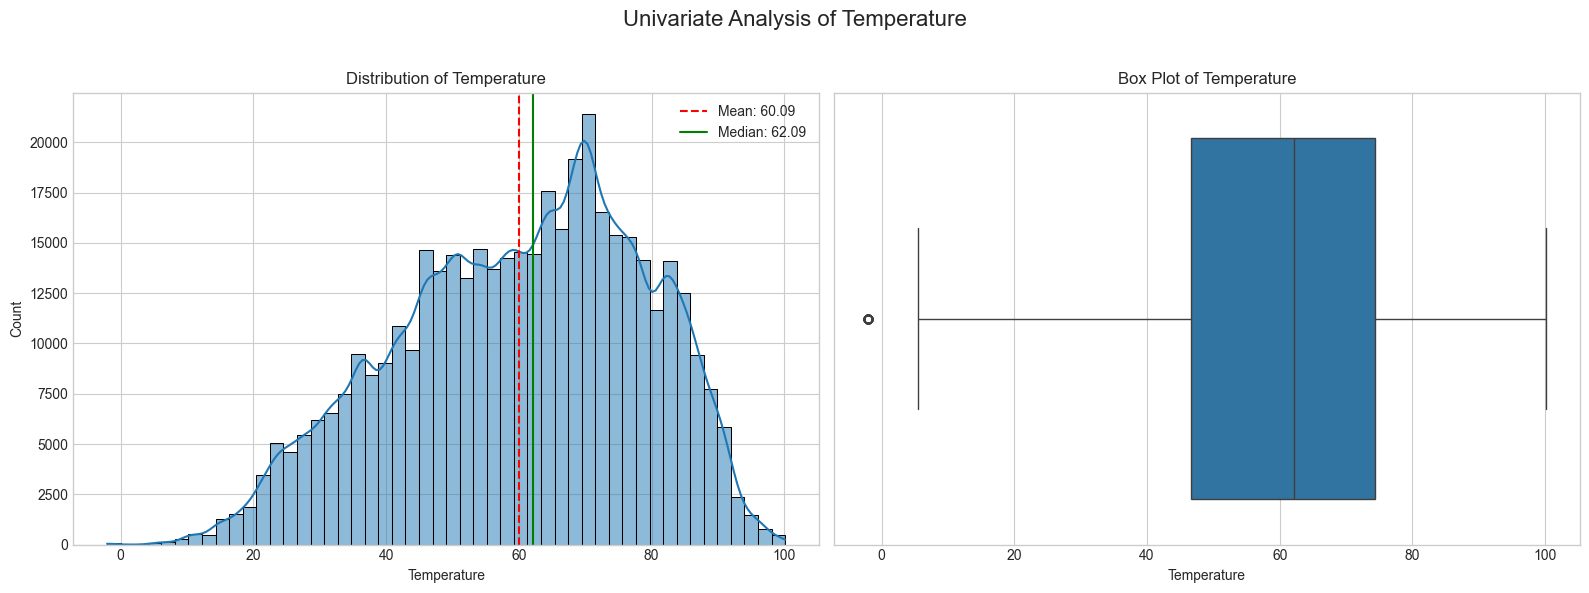

Skewness of Temperature: -0.32
Kurtosis of Temperature: -0.64


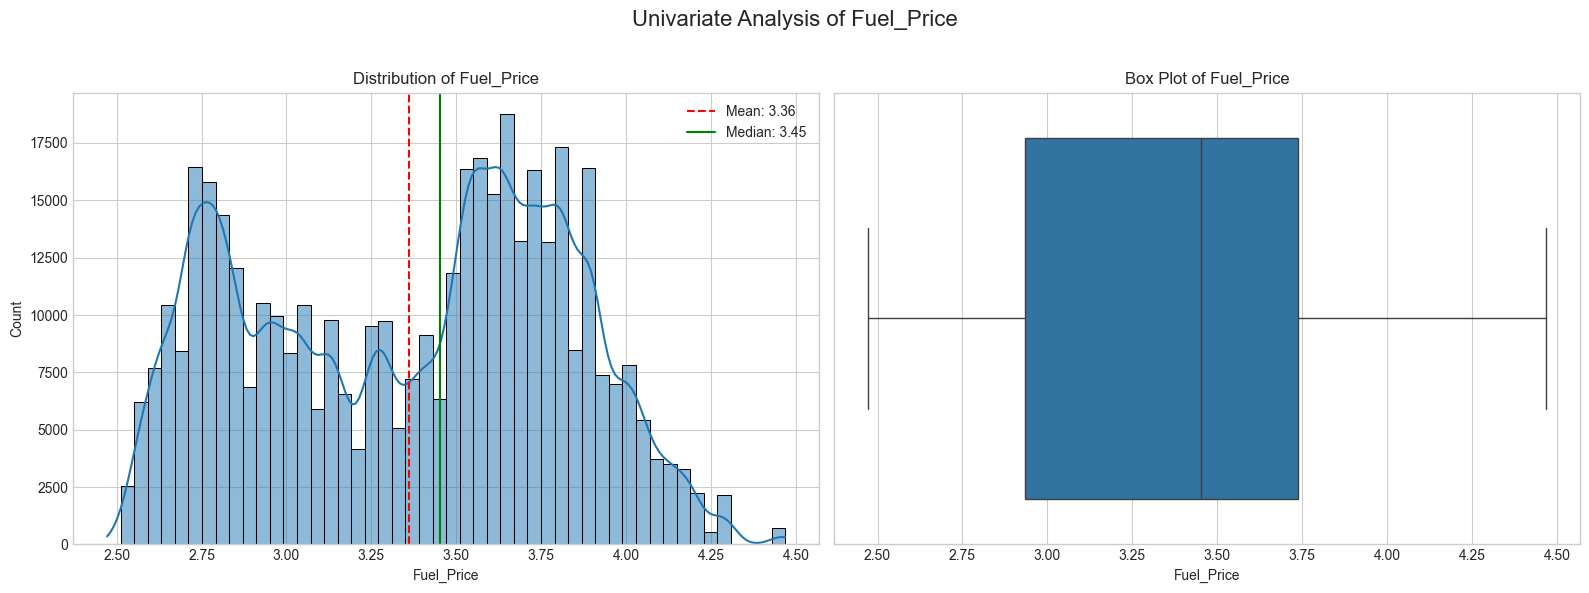

Skewness of Fuel_Price: -0.10
Kurtosis of Fuel_Price: -1.19


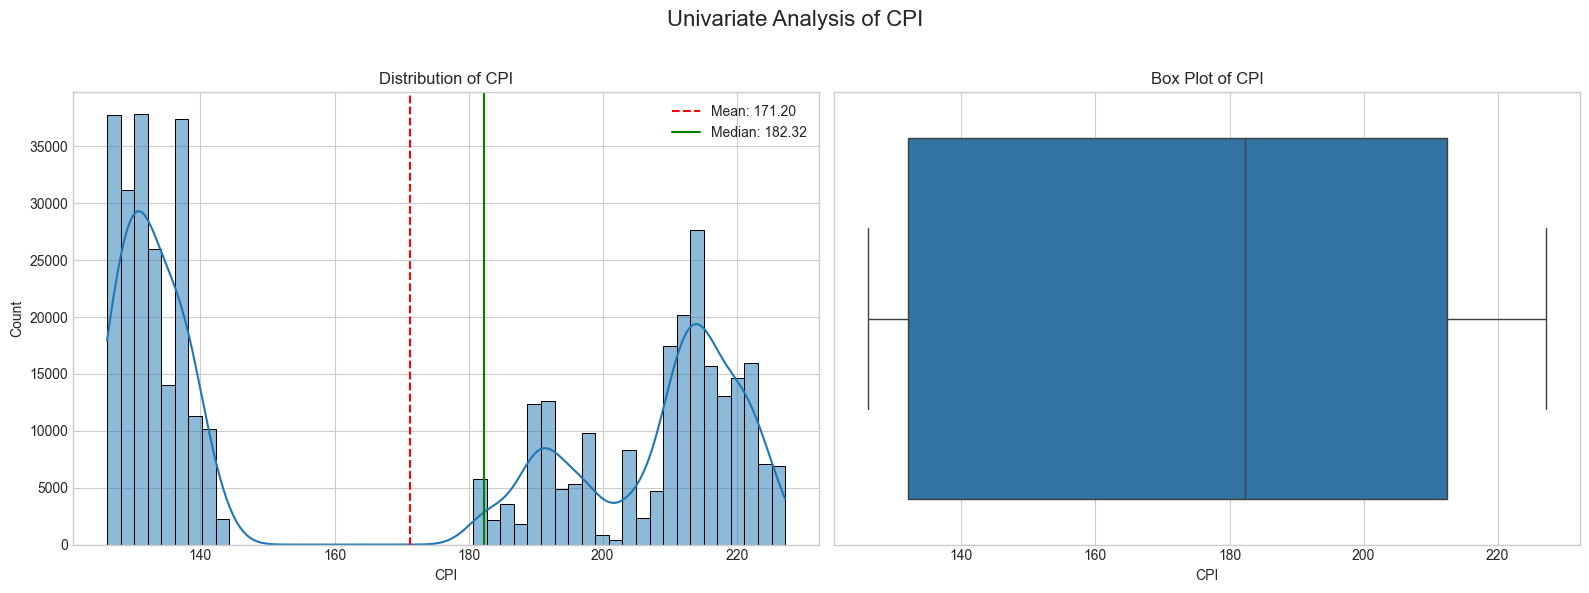

Skewness of CPI: 0.09
Kurtosis of CPI: -1.83


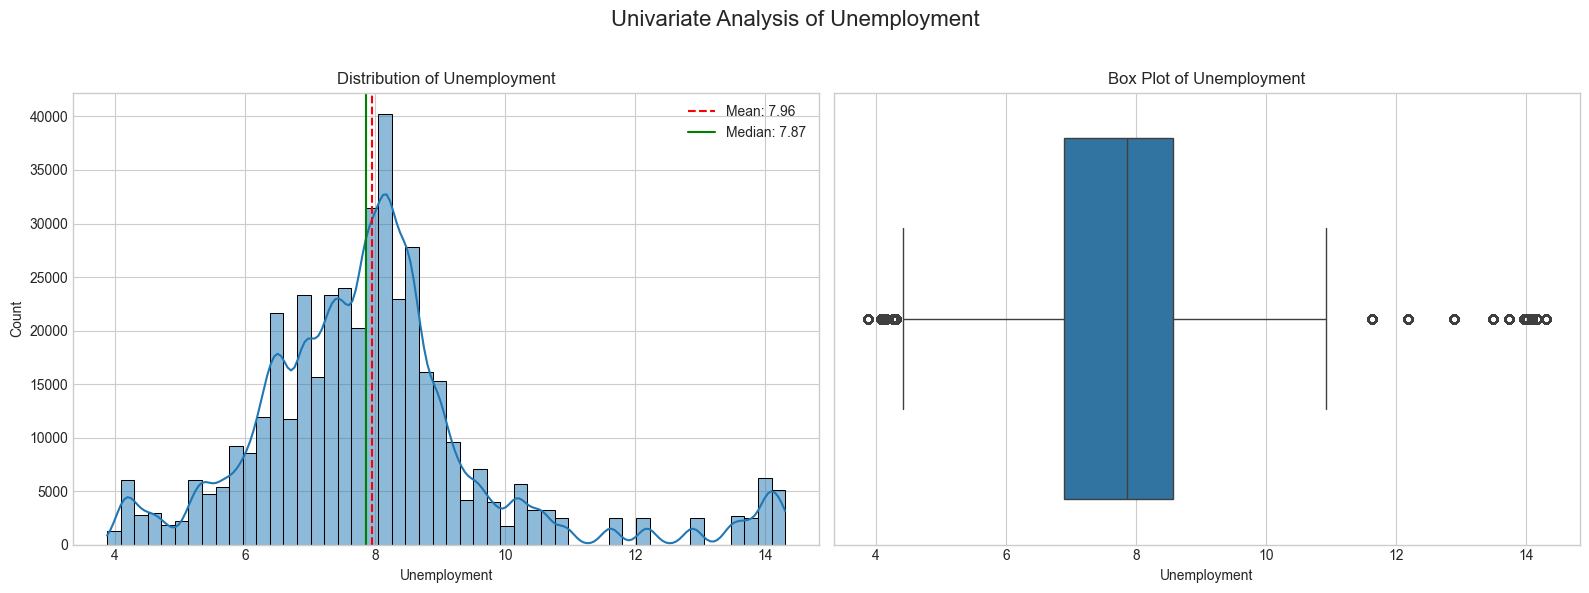

Skewness of Unemployment: 1.18
Kurtosis of Unemployment: 2.73


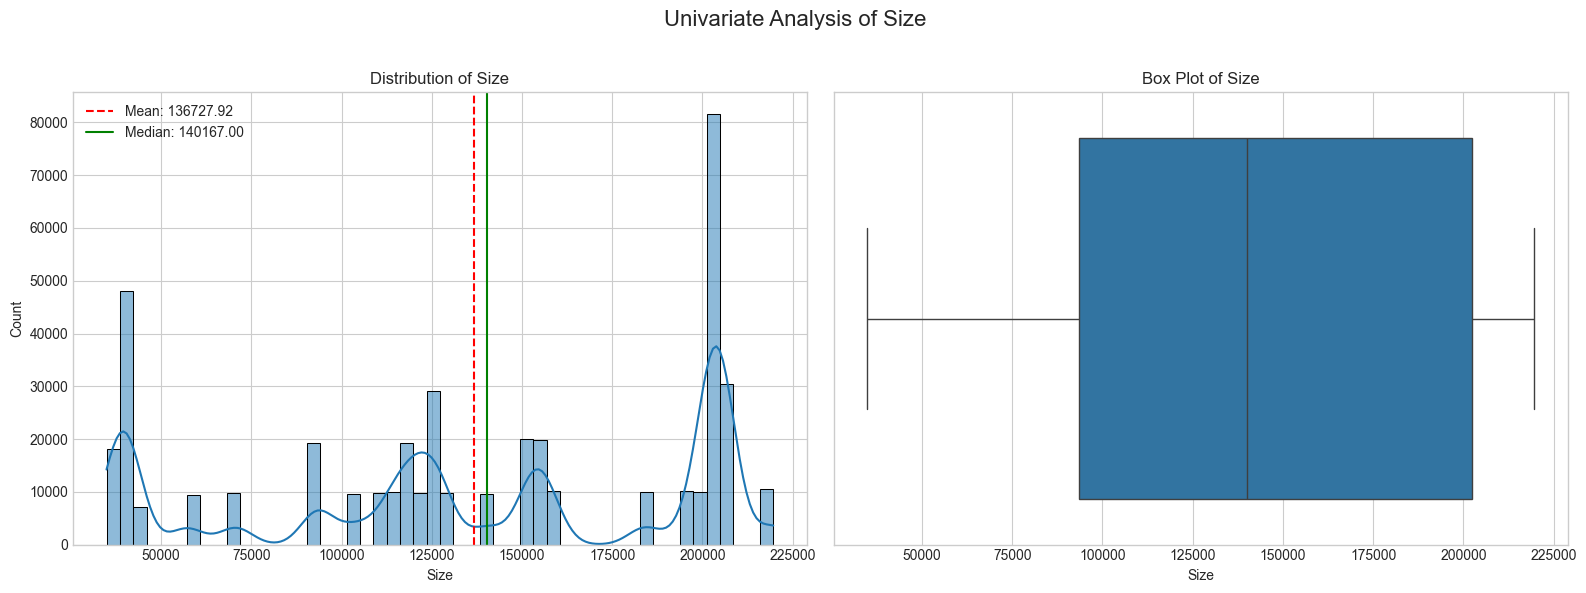

Skewness of Size: -0.33
Kurtosis of Size: -1.21


In [7]:
def plot_numerical_distribution(df: pd.DataFrame, column_name: str, bins: int = 50):
    """
    Plots the distribution (histogram and boxplot) of a numerical column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the numerical column to plot.
        bins (int): Number of bins for the histogram.
    """
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name], kde=True, bins=bins)
    plt.title(f'Distribution of {column_name}')
    plt.axvline(df[column_name].mean(), color='r', linestyle='--', label=f"Mean: {df[column_name].mean():.2f}")
    plt.axvline(df[column_name].median(), color='g', linestyle='-', label=f"Median: {df[column_name].median():.2f}")
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column_name])
    plt.title(f'Box Plot of {column_name}')

    plt.suptitle(f'Univariate Analysis of {column_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()
    print(f"Skewness of {column_name}: {df[column_name].skew():.2f}")
    print(f"Kurtosis of {column_name}: {df[column_name].kurtosis():.2f}")


if df is not None:
    print("\n--- Univariate Analysis of Key Numerical Features ---")
    numerical_features_to_plot = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
    for feature in numerical_features_to_plot:
        if feature in df.columns:
            plot_numerical_distribution(df, feature)
        else:
            print(f"Feature '{feature}' not found for univariate analysis.")
else:
    print("DataFrame 'df' is None. Skipping Univariate Analysis of Numerical Features.")


--- Univariate Analysis of Key Categorical Features ---

Value counts for Store (Top 20):
Store
13    2.484522
10    2.446806
4     2.436606
1     2.429964
2     2.428541
24    2.426169
27    2.425457
34    2.425220
20    2.422848
6     2.422136
32    2.420001
19    2.407192
31    2.405769
28    2.398890
41    2.392960
11    2.386792
23    2.383946
14    2.381574
40    2.376118
15    2.348602
Name: proportion, dtype: float64


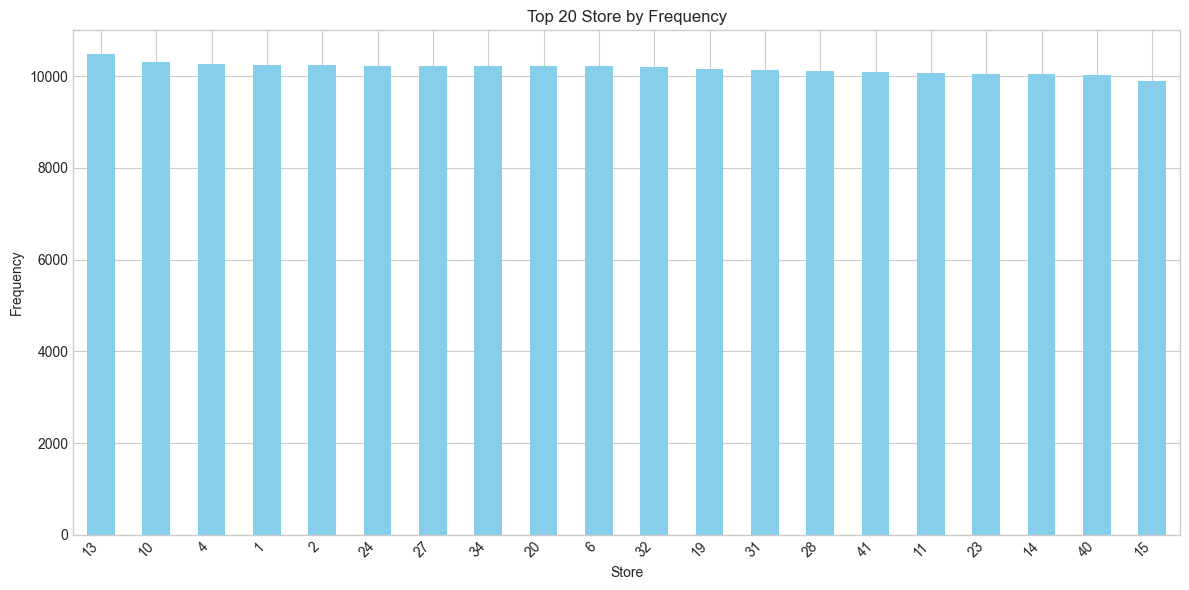


Value counts for Dept (Top 20):
Dept
1     1.526437
16    1.526437
92    1.526437
38    1.526437
40    1.526437
2     1.526437
82    1.526437
46    1.526437
95    1.526437
81    1.526437
79    1.526437
21    1.526437
90    1.526437
91    1.526437
14    1.526437
4     1.526437
13    1.526437
3     1.526437
10    1.526437
8     1.526437
Name: proportion, dtype: float64


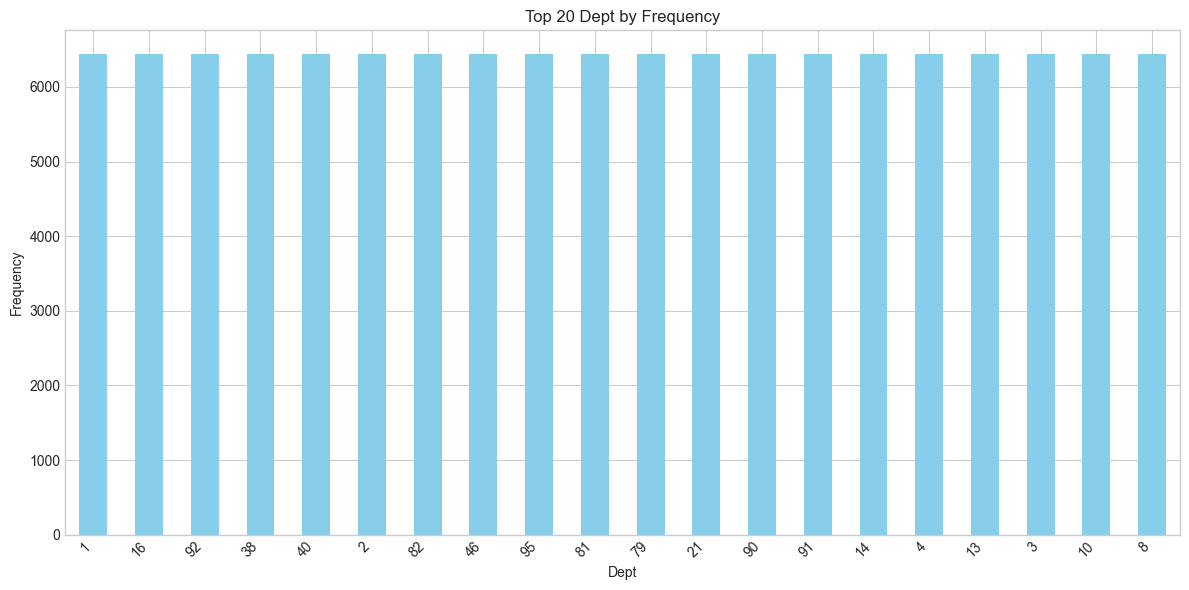

/var/folders/q2/7hnc3ms1333dvg43gyhqwgt40000gn/T/ipykernel_79126/4089592224.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index, palette='viridis')


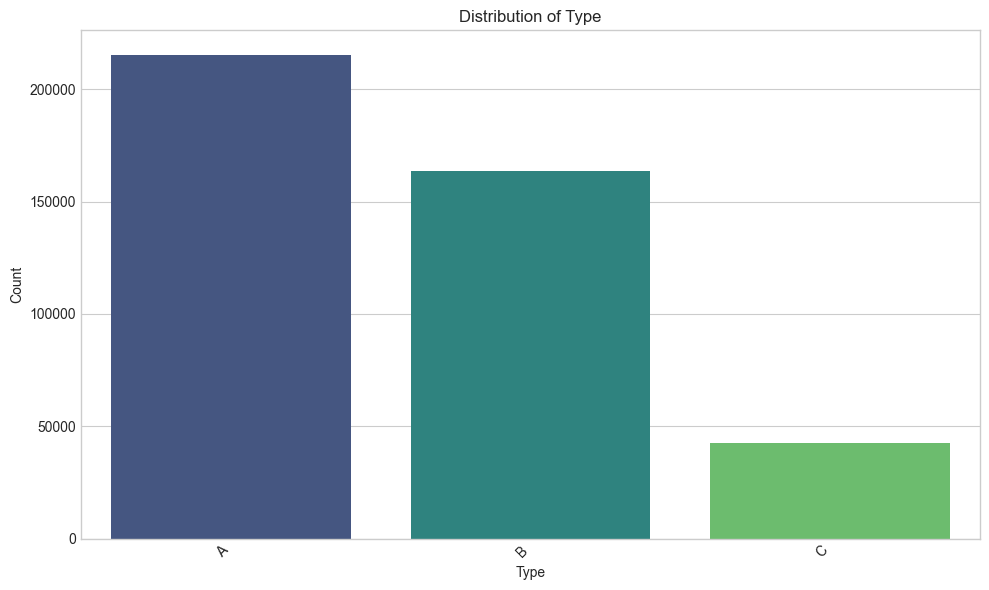


Value counts for Type:
Type
A    51.113220
B    38.782409
C    10.104372
Name: proportion, dtype: float64


/var/folders/q2/7hnc3ms1333dvg43gyhqwgt40000gn/T/ipykernel_79126/4089592224.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index, palette='viridis')


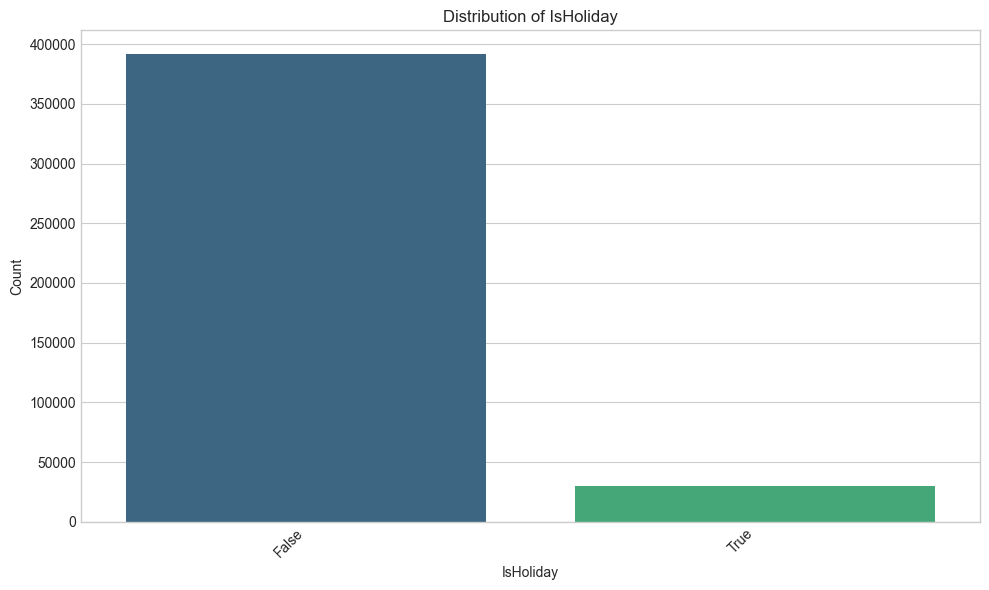


Value counts for IsHoliday:
IsHoliday
False    92.964158
True      7.035842
Name: proportion, dtype: float64


In [ ]:
def plot_categorical_distribution(df: pd.DataFrame, column_name: str):
    """
    Plots the distribution (count plot) of a categorical column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the categorical column to plot.
    """
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index, palette='viridis')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they are long
    plt.tight_layout()
    plt.show()
    print(f"\nValue counts for {column_name}:\n{df[column_name].value_counts(normalize=True) * 100}")


if df is not None:
    print("\n--- Univariate Analysis of Key Categorical Features ---")
    categorical_features_to_plot = ['Store', 'Dept', 'Type', 'IsHoliday']
    for feature in categorical_features_to_plot:
        if feature in df.columns:
            if feature in ['Store', 'Dept'] and df[feature].nunique() > 20: # Only print value counts for many unique values
                print(f"\nValue counts for {feature} (Top 20):\n{df[feature].value_counts(normalize=True).head(20) * 100}")
                plt.figure(figsize=(12,6))
                df[feature].value_counts().nlargest(20).plot(kind='bar', color='skyblue')
                plt.title(f'Top 20 {feature} by Frequency')
                plt.ylabel('Frequency')
                plt.xlabel(feature)
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()

            else:
                plot_categorical_distribution(df, feature)
        else:
            print(f"Feature '{feature}' not found for univariate analysis.")
else:
    print("DataFrame 'df' is None. Skipping Univariate Analysis of Categorical Features.")


--- Bivariate Analysis: Numerical Features vs. Weekly_Sales ---


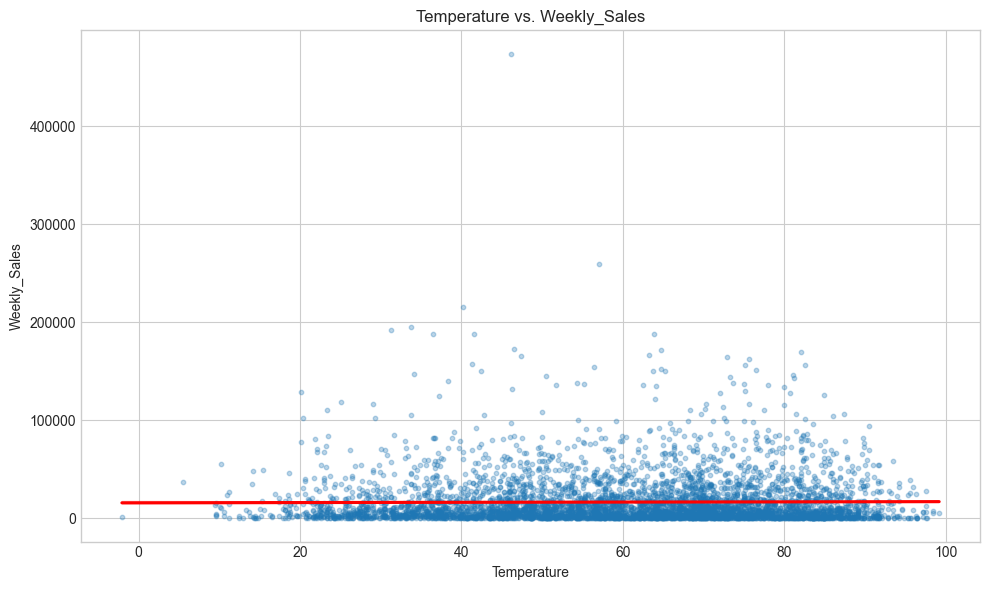

Correlation between Temperature and Weekly_Sales: -0.002


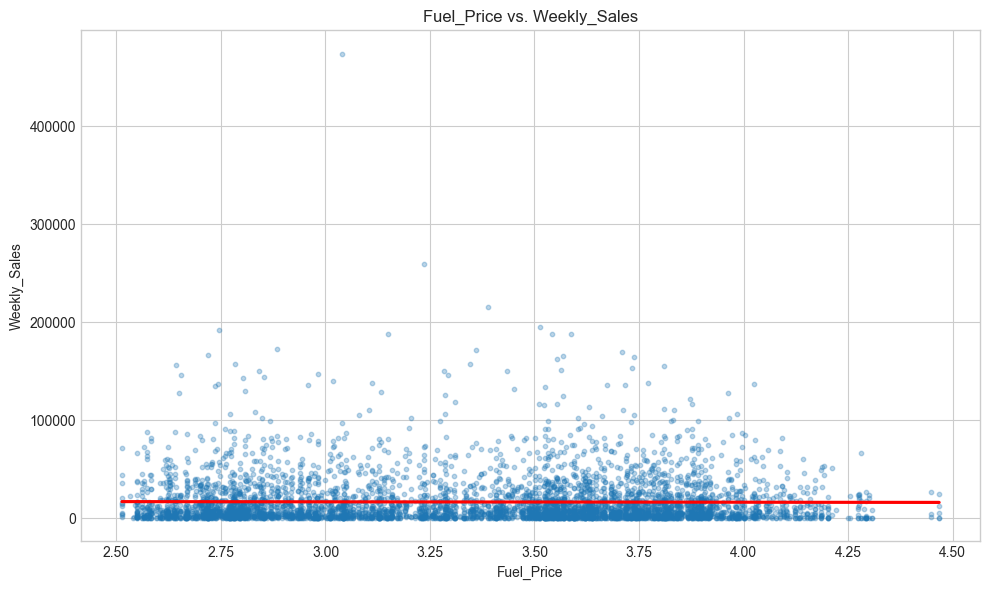

Correlation between Fuel_Price and Weekly_Sales: -0.000


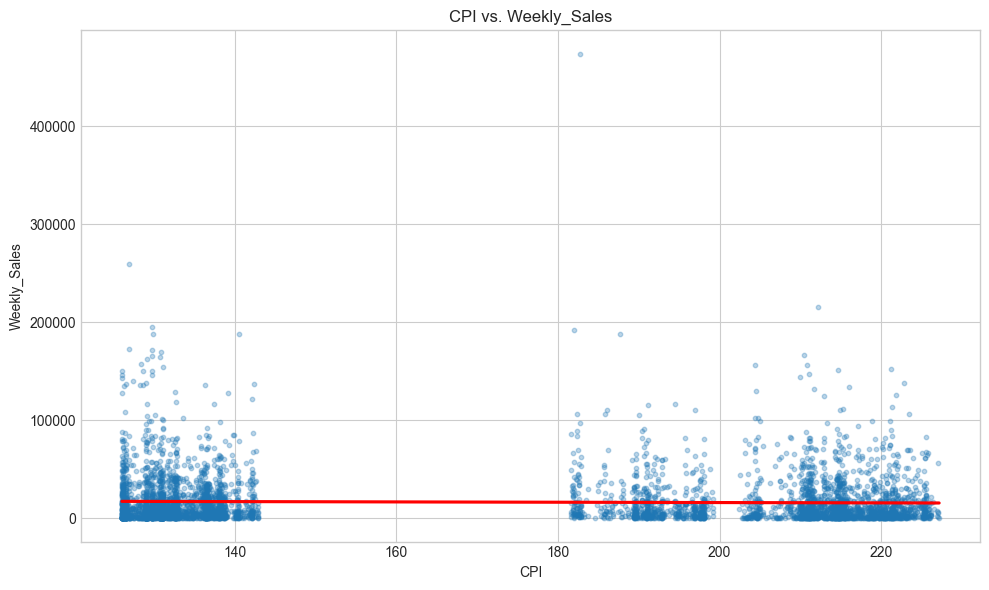

Correlation between CPI and Weekly_Sales: -0.021


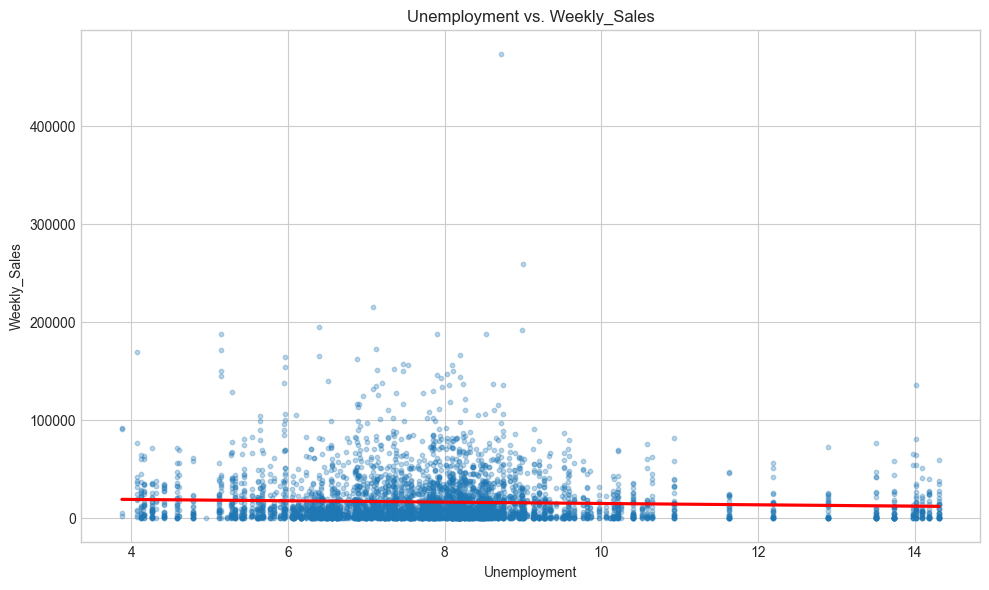

Correlation between Unemployment and Weekly_Sales: -0.026


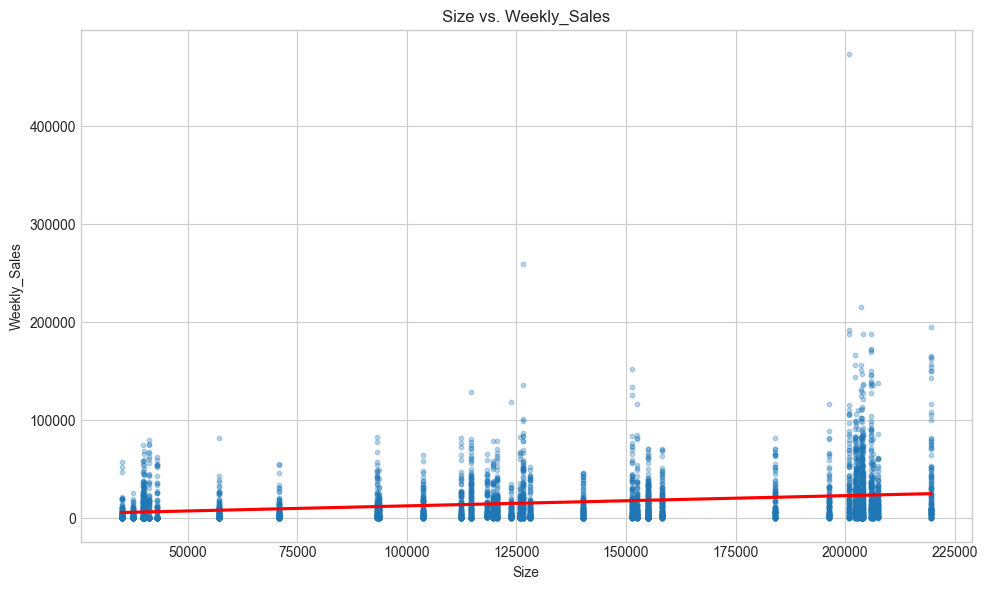

Correlation between Size and Weekly_Sales: 0.244


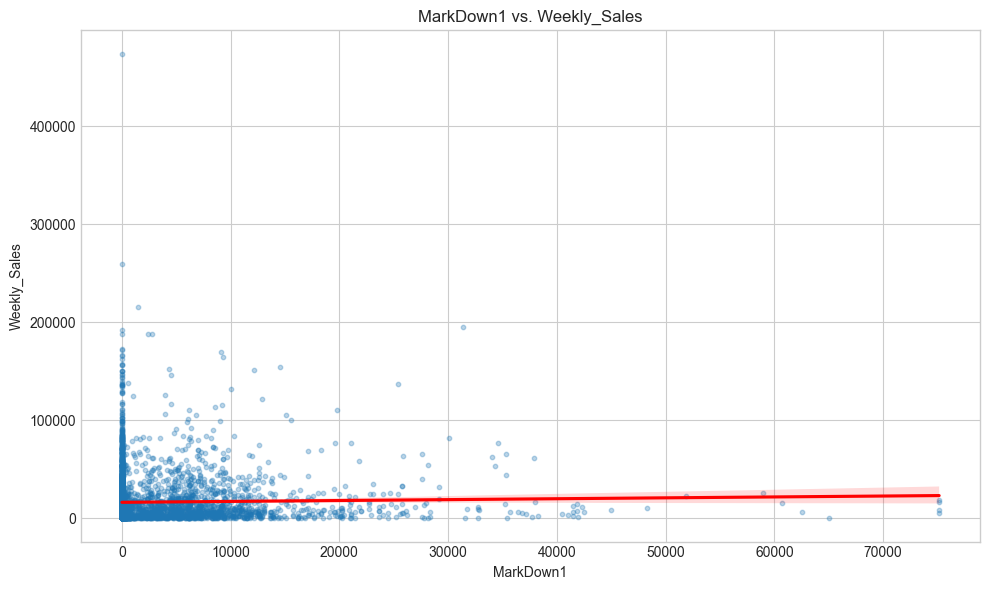

Correlation between MarkDown1 and Weekly_Sales: 0.047


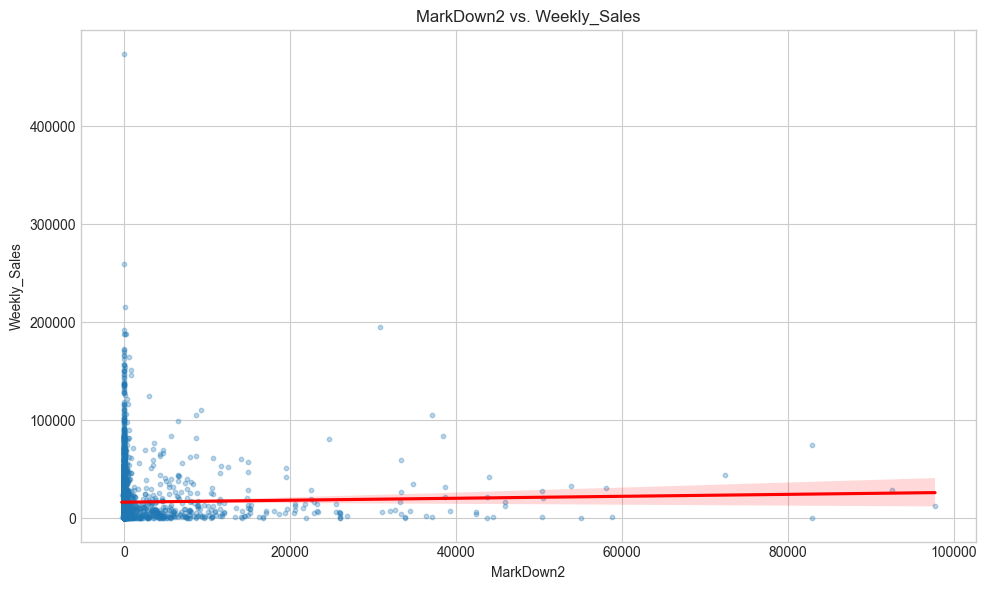

Correlation between MarkDown2 and Weekly_Sales: 0.021


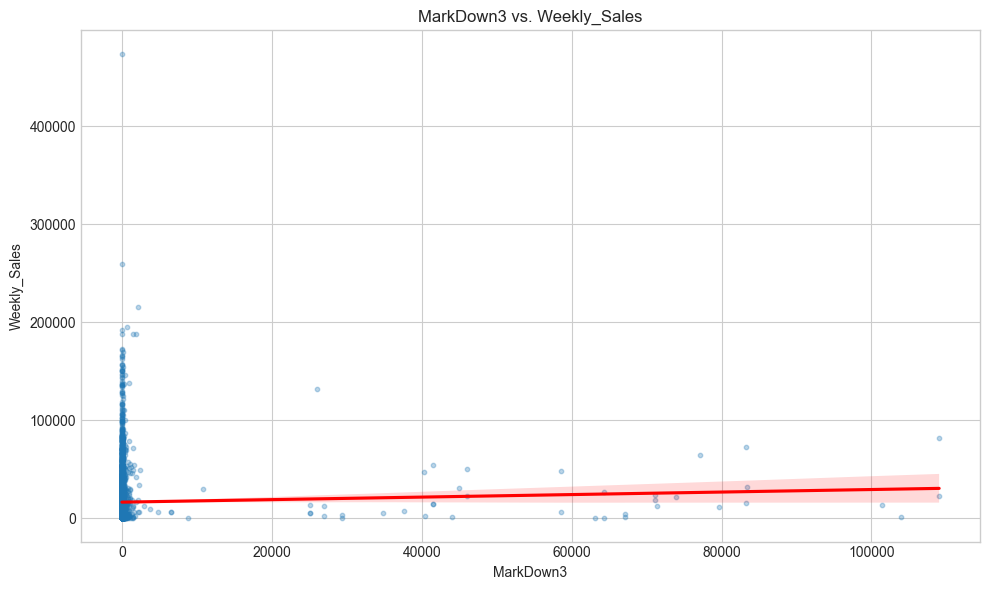

Correlation between MarkDown3 and Weekly_Sales: 0.039


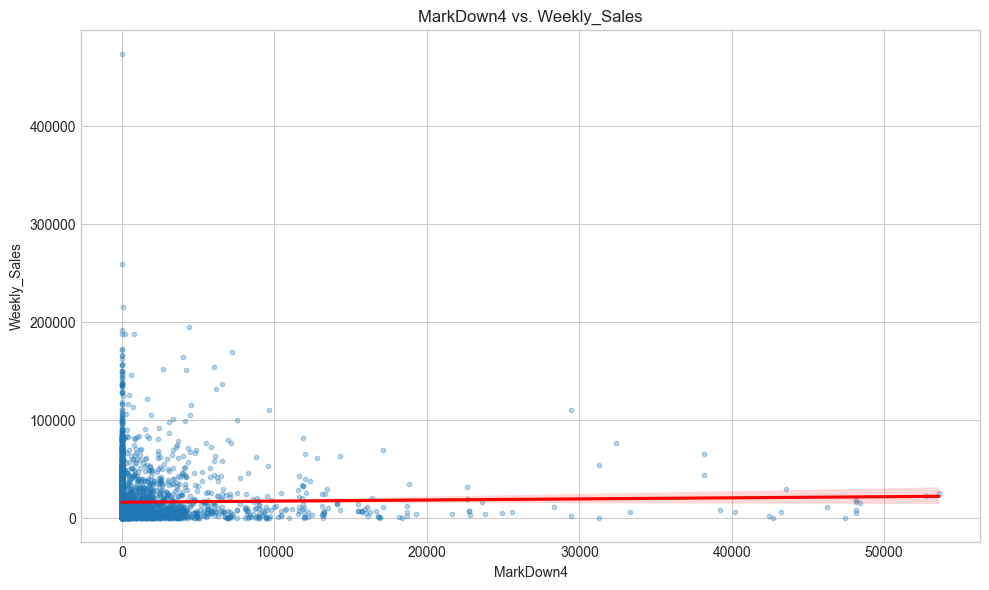

Correlation between MarkDown4 and Weekly_Sales: 0.037


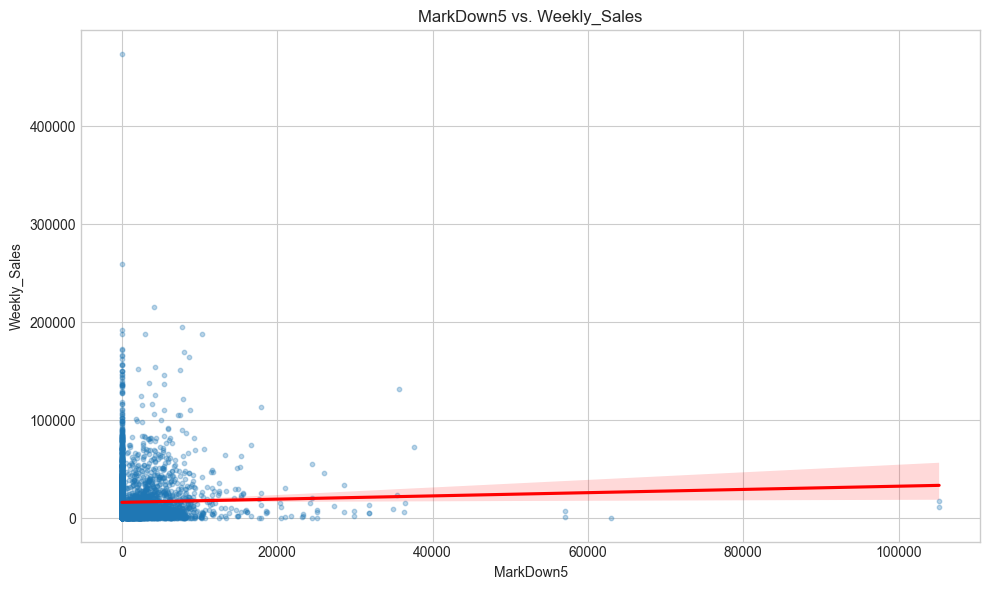

Correlation between MarkDown5 and Weekly_Sales: 0.050


In [ ]:
def plot_numerical_vs_target(df: pd.DataFrame, numerical_col: str, target_col: str = 'Weekly_Sales'):
    """
    Plots a scatter plot of a numerical feature against the target variable.
    Also shows a regression line to indicate trend.

    Args:
        df (pd.DataFrame): The input DataFrame.
        numerical_col (str): The name of the numerical feature column.
        target_col (str, optional): The name of the target variable column. Defaults to 'Weekly_Sales'.
    """
    if numerical_col not in df.columns:
        print(f"Column '{numerical_col}' not found in DataFrame.")
        return
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found in DataFrame.")
        return

    plt.figure(figsize=(10, 6))
    sample_df = df.sample(n=min(5000, len(df)), random_state=42) if len(df) > 5000 else df

    sns.regplot(data=sample_df, x=numerical_col, y=target_col,
                scatter_kws={'alpha':0.3, 's':10},  # Make points semi-transparent and smaller
                line_kws={'color':'red'})
    plt.title(f'{numerical_col} vs. {target_col}')
    plt.xlabel(numerical_col)
    plt.ylabel(target_col)
    plt.tight_layout()
    plt.show()
    
    # Print correlation
    if pd.api.types.is_numeric_dtype(df[numerical_col]) and pd.api.types.is_numeric_dtype(df[target_col]):
        correlation = df[numerical_col].corr(df[target_col])
        print(f"Correlation between {numerical_col} and {target_col}: {correlation:.3f}")


if df is not None:
    print("\n--- Bivariate Analysis: Numerical Features vs. Weekly_Sales ---")
    numerical_features_for_bivariate = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size',
                                        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for feature in numerical_features_for_bivariate:
        if feature in df.columns:
            plot_numerical_vs_target(df, feature)
        else:
            print(f"Feature '{feature}' not found for bivariate analysis.")
else:
    print("DataFrame 'df' is None. Skipping Bivariate Analysis of Numerical Features.")


--- Bivariate Analysis: Categorical Features vs. Weekly_Sales ---
'Store' has high cardinality (45). Plotting mean Weekly_Sales for top 20 categories.


/var/folders/q2/7hnc3ms1333dvg43gyhqwgt40000gn/T/ipykernel_79126/3512711780.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories_mean_sales.index, y=top_categories_mean_sales.values, palette='viridis', order=top_categories_mean_sales.index)


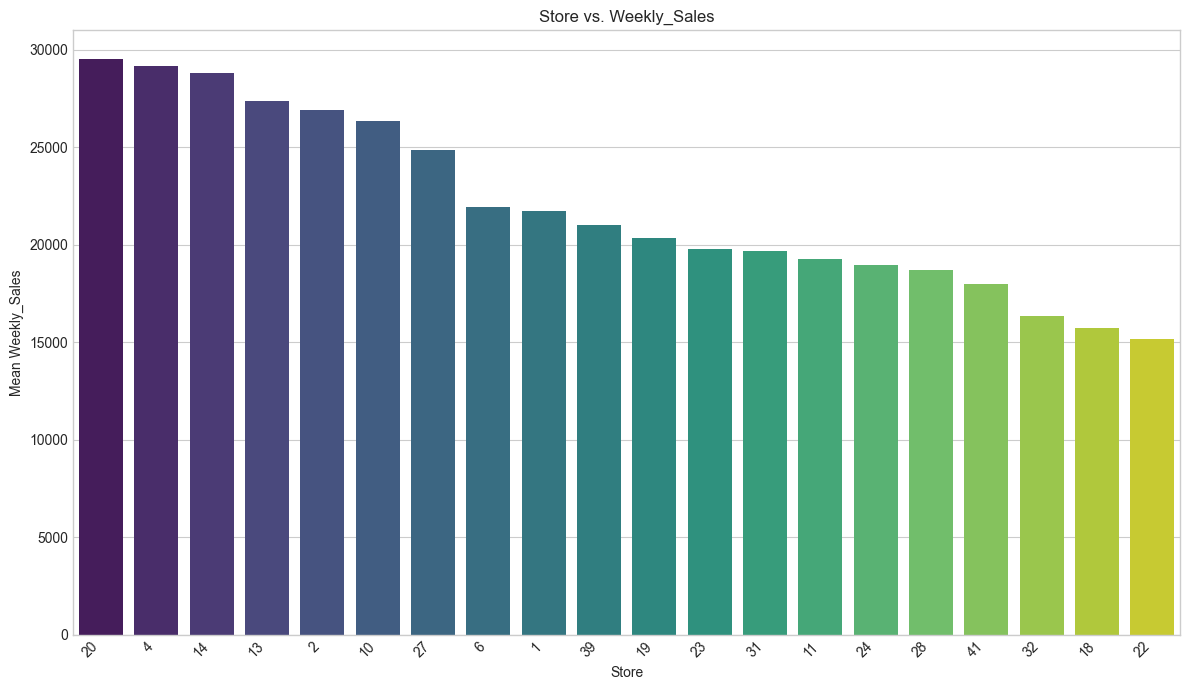

/var/folders/q2/7hnc3ms1333dvg43gyhqwgt40000gn/T/ipykernel_79126/3512711780.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories_mean_sales.index, y=top_categories_mean_sales.values, palette='viridis', order=top_categories_mean_sales.index)


'Dept' has high cardinality (81). Plotting mean Weekly_Sales for top 20 categories.


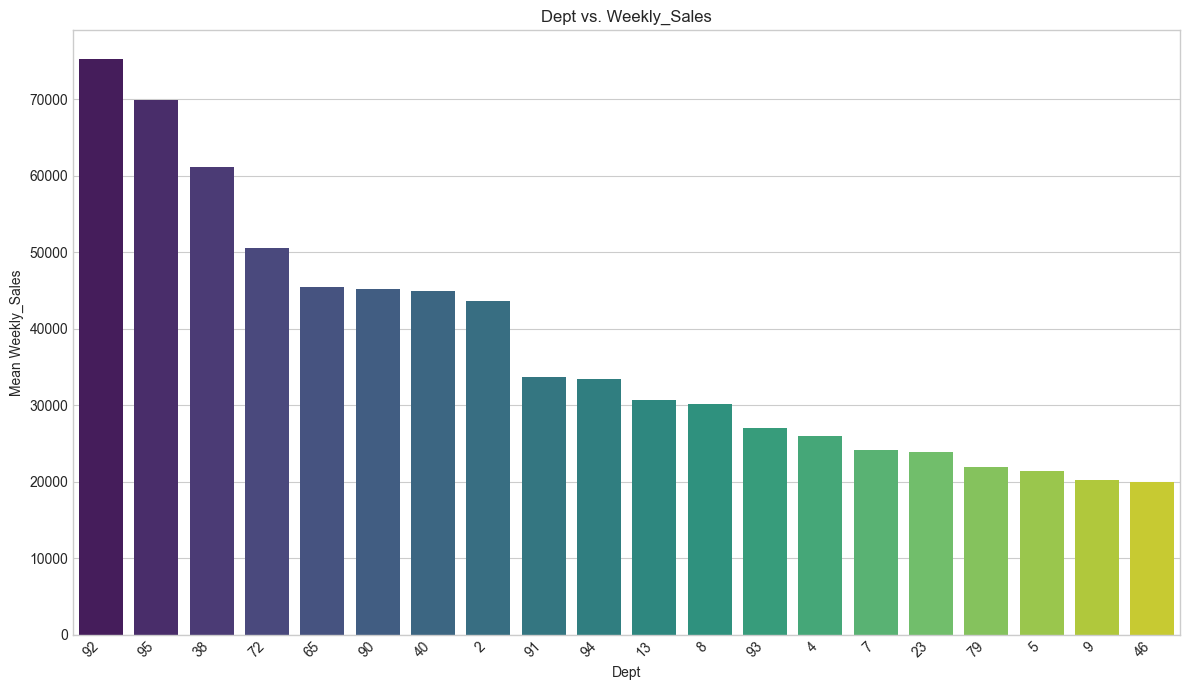

/var/folders/q2/7hnc3ms1333dvg43gyhqwgt40000gn/T/ipykernel_79126/3512711780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=categorical_col, y=target_col, palette='viridis', order=sorted(df[categorical_col].unique().tolist()) if df[categorical_col].nunique() <=5 else None) # Sort for few unique values


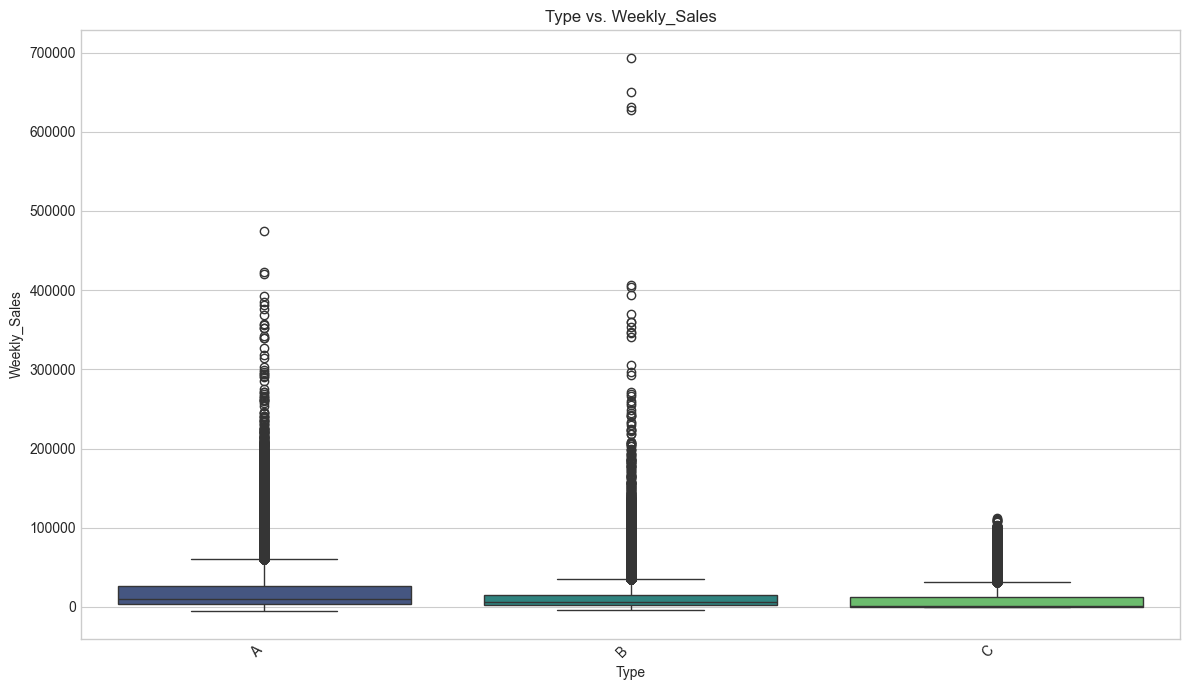

/var/folders/q2/7hnc3ms1333dvg43gyhqwgt40000gn/T/ipykernel_79126/3512711780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=categorical_col, y=target_col, palette='viridis', order=sorted(df[categorical_col].unique().tolist()) if df[categorical_col].nunique() <=5 else None) # Sort for few unique values


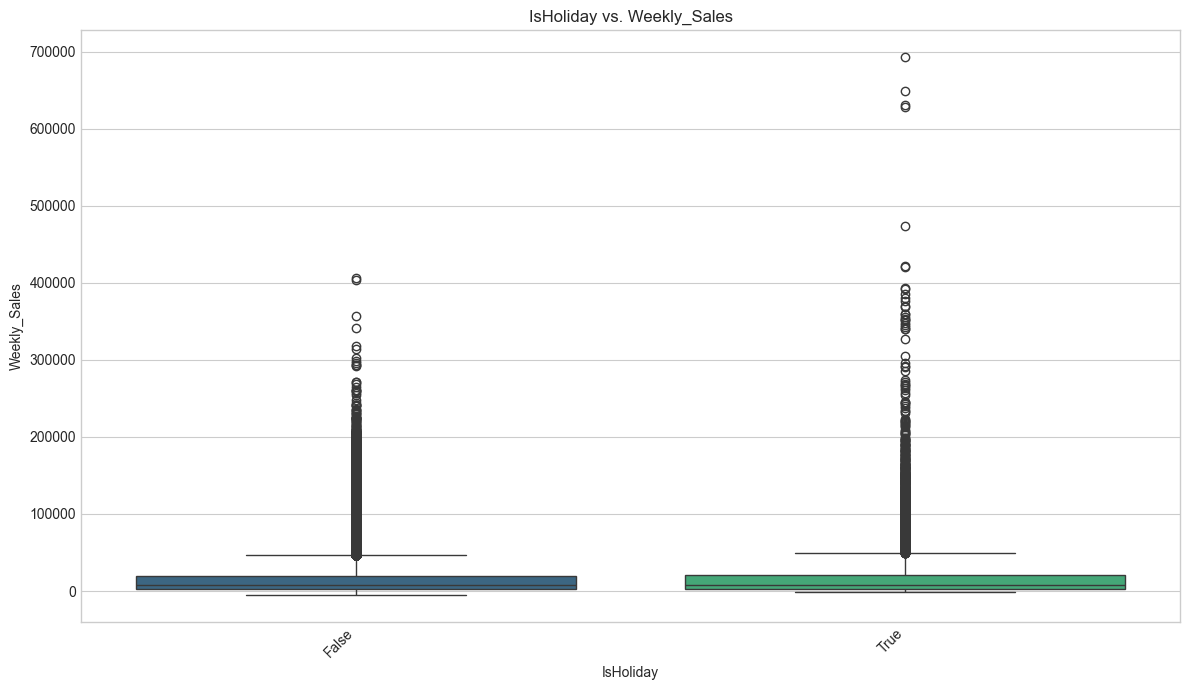

/var/folders/q2/7hnc3ms1333dvg43gyhqwgt40000gn/T/ipykernel_79126/3512711780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=categorical_col, y=target_col, palette='viridis', order=sorted(df[categorical_col].unique().tolist()) if df[categorical_col].nunique() <=5 else None) # Sort for few unique values


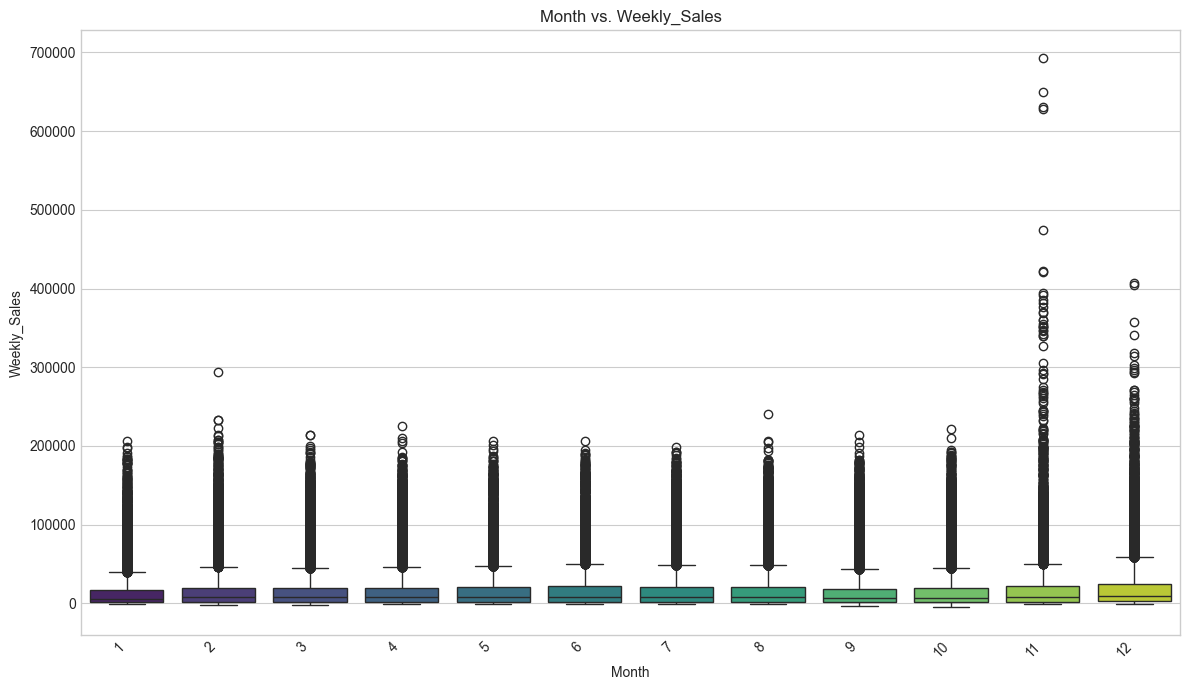

'WeekOfYear' has high cardinality (52). Plotting mean Weekly_Sales for top 20 categories.


/var/folders/q2/7hnc3ms1333dvg43gyhqwgt40000gn/T/ipykernel_79126/3512711780.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories_mean_sales.index, y=top_categories_mean_sales.values, palette='viridis', order=top_categories_mean_sales.index)


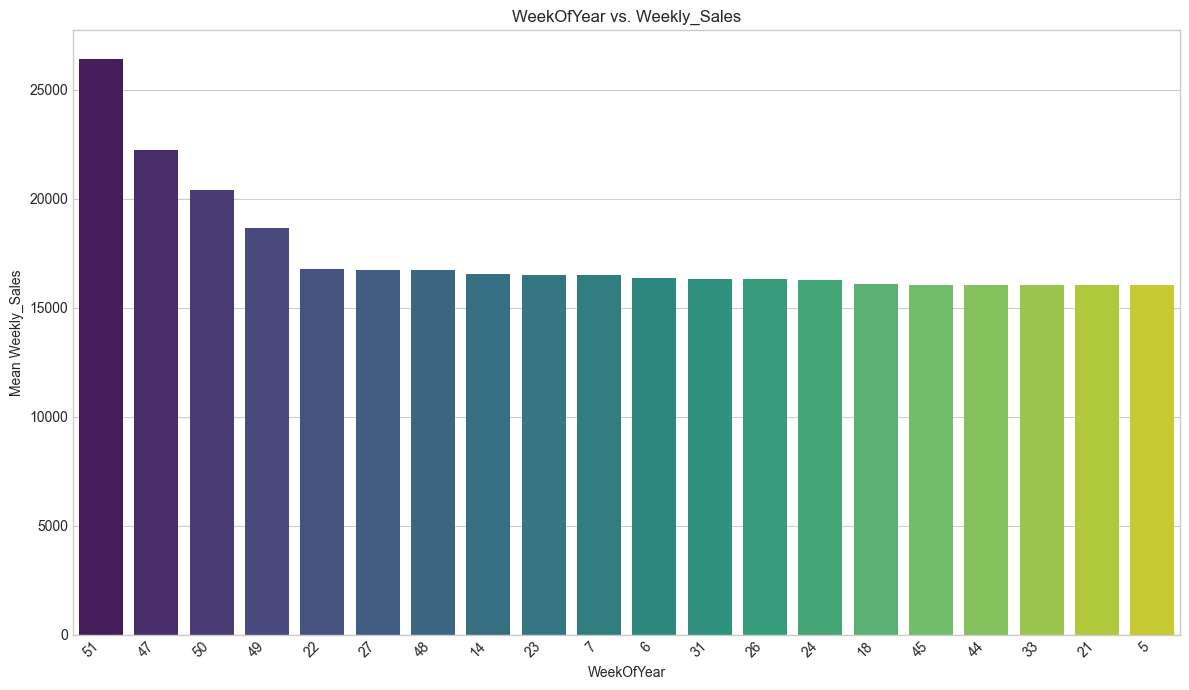

In [10]:
def plot_categorical_vs_target(df: pd.DataFrame, categorical_col: str, target_col: str = 'Weekly_Sales'):
    """
    Plots a box plot of a categorical feature against the target variable.

    Args:
        df (pd.DataFrame): The input DataFrame.
        categorical_col (str): The name of the categorical feature column.
        target_col (str, optional): The name of the target variable column. Defaults to 'Weekly_Sales'.
    """
    if categorical_col not in df.columns:
        print(f"Column '{categorical_col}' not found in DataFrame.")
        return
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found in DataFrame.")
        return

    plt.figure(figsize=(12, 7))
    # If cardinality is too high, consider plotting top N categories or aggregating
    if df[categorical_col].nunique() > 20 and categorical_col not in ['Type', 'IsHoliday']: # Example threshold
        print(f"'{categorical_col}' has high cardinality ({df[categorical_col].nunique()}). Plotting mean {target_col} for top 20 categories.")
        top_categories_mean_sales = df.groupby(categorical_col)[target_col].mean().nlargest(20)
        sns.barplot(x=top_categories_mean_sales.index, y=top_categories_mean_sales.values, palette='viridis', order=top_categories_mean_sales.index)
        plt.ylabel(f'Mean {target_col}')
    else:
        sns.boxplot(data=df, x=categorical_col, y=target_col, palette='viridis', order=sorted(df[categorical_col].unique().tolist()) if df[categorical_col].nunique() <=5 else None) # Sort for few unique values
        plt.ylabel(target_col)

    plt.title(f'{categorical_col} vs. {target_col}')
    plt.xlabel(categorical_col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


if df is not None:
    print("\n--- Bivariate Analysis: Categorical Features vs. Weekly_Sales ---")
    categorical_features_for_bivariate = ['Store', 'Dept', 'Type', 'IsHoliday', 'Month', 'WeekOfYear'] # Added Month, WeekOfYear
    
    # Create 'Month' and 'WeekOfYear' if not present from feature engineering step
    if 'Month' not in df.columns and 'Date' in df.columns:
        df['Month'] = df['Date'].dt.month
    if 'WeekOfYear' not in df.columns and 'Date' in df.columns:
        df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    for feature in categorical_features_for_bivariate:
        if feature in df.columns:
            plot_categorical_vs_target(df, feature)
        else:
            print(f"Feature '{feature}' not found for bivariate analysis.")
else:
    print("DataFrame 'df' is None. Skipping Bivariate Analysis of Categorical Features.")

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_time_series(df: pd.DataFrame, date_col: str, value_col: str, title: str,
                     xlabel: str = 'Date', ylabel: str = 'Value'):
    """
    Plots a time series.

    Args:
        df (pd.DataFrame): DataFrame containing the time series data.
        date_col (str): Name of the column containing date/time information.
        value_col (str): Name of the column containing the values to plot.
        title (str): Title of the plot.
        xlabel (str, optional): Label for the x-axis. Defaults to 'Date'.
        ylabel (str, optional): Label for the y-axis. Defaults to 'Value'.
    """
    if date_col not in df.columns or value_col not in df.columns:
        print(f"Error: Columns '{date_col}' or '{value_col}' not found.")
        return

    plt.figure(figsize=(18, 6))
    plt.plot(df[date_col], df[value_col], label=value_col)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_seasonal_decomposition(series: pd.Series, model: str = 'additive', period: int = 52):
    """
    Plots the seasonal decomposition of a time series.

    Args:
        series (pd.Series): Time series data (index must be datetime).
        model (str, optional): Type of decomposition ('additive' or 'multiplicative'). Defaults to 'additive'.
        period (int, optional): The period of the seasonality. For weekly data with yearly seasonality, this is 52.
    """
    if not isinstance(series.index, pd.DatetimeIndex):
        print("Error: Series index must be a DatetimeIndex for seasonal decomposition.")
        return
    
    # Ensure there are enough periods for decomposition
    if len(series) < 2 * period:
        print(f"Error: Time series too short for seasonal decomposition with period {period}. Needs at least {2*period} observations.")
        return

    try:
        decomposition = seasonal_decompose(series, model=model, period=period)
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
        
        decomposition.observed.plot(ax=ax1, legend=False)
        ax1.set_ylabel('Observed')
        ax1.set_title(f'Seasonal Decomposition (Model: {model}, Period: {period})', fontsize=16)
        
        decomposition.trend.plot(ax=ax2, legend=False)
        ax2.set_ylabel('Trend')
        
        decomposition.seasonal.plot(ax=ax3, legend=False)
        ax3.set_ylabel('Seasonal')
        
        decomposition.resid.plot(ax=ax4, legend=False)
        ax4.set_ylabel('Residual')
        
        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error during seasonal decomposition: {e}")


def plot_acf_pacf(series: pd.Series, lags: int = 40):
    """
    Plots the ACF and PACF for a time series.

    Args:
        series (pd.Series): Time series data.
        lags (int, optional): Number of lags to display. Defaults to 40.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    plot_acf(series.dropna(), lags=lags, ax=ax1)
    ax1.set_title('Autocorrelation Function (ACF)')
    
    plot_pacf(series.dropna(), lags=lags, ax=ax2, method='ywm') # 'ywm' is often preferred
    ax2.set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

print("Time series helper functions defined.")

Time series helper functions defined.



--- Time Series EDA: Overall Weekly Sales ---


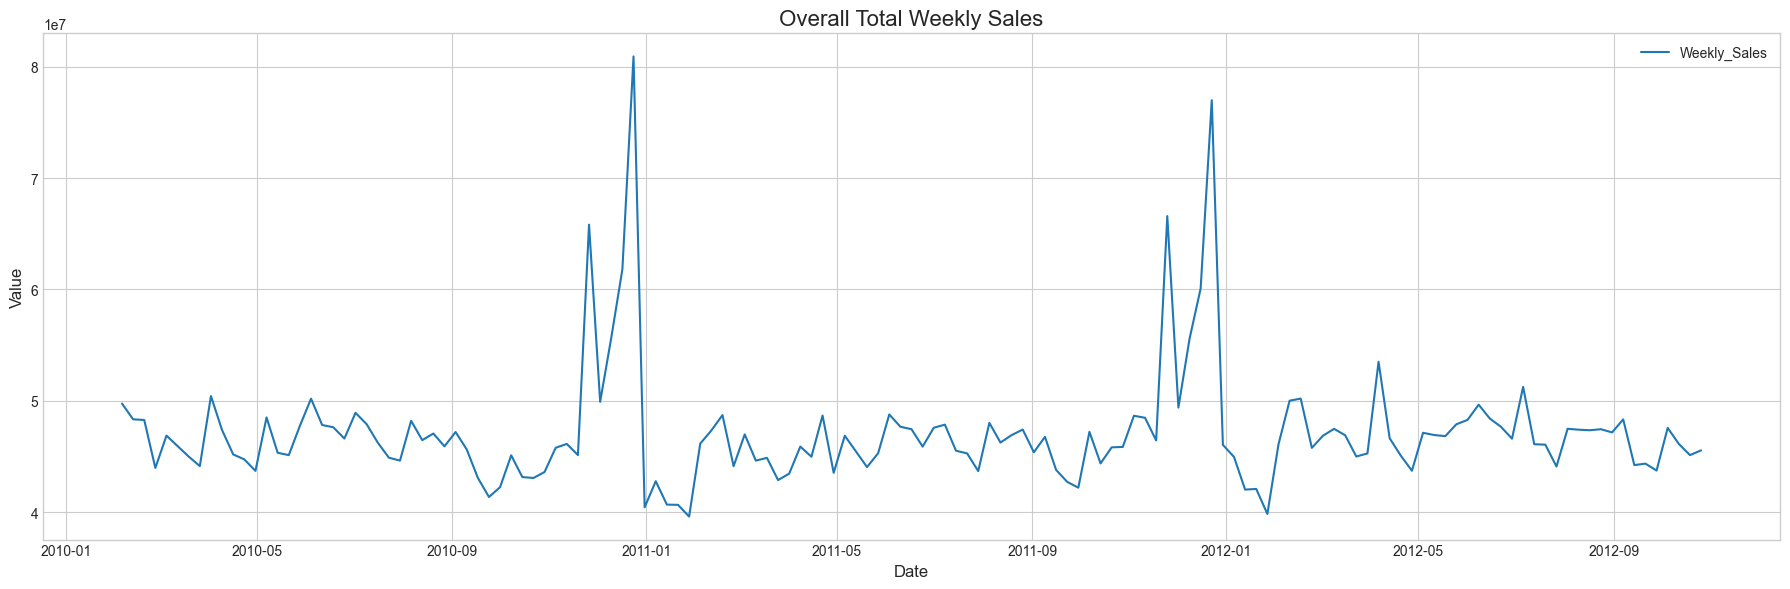

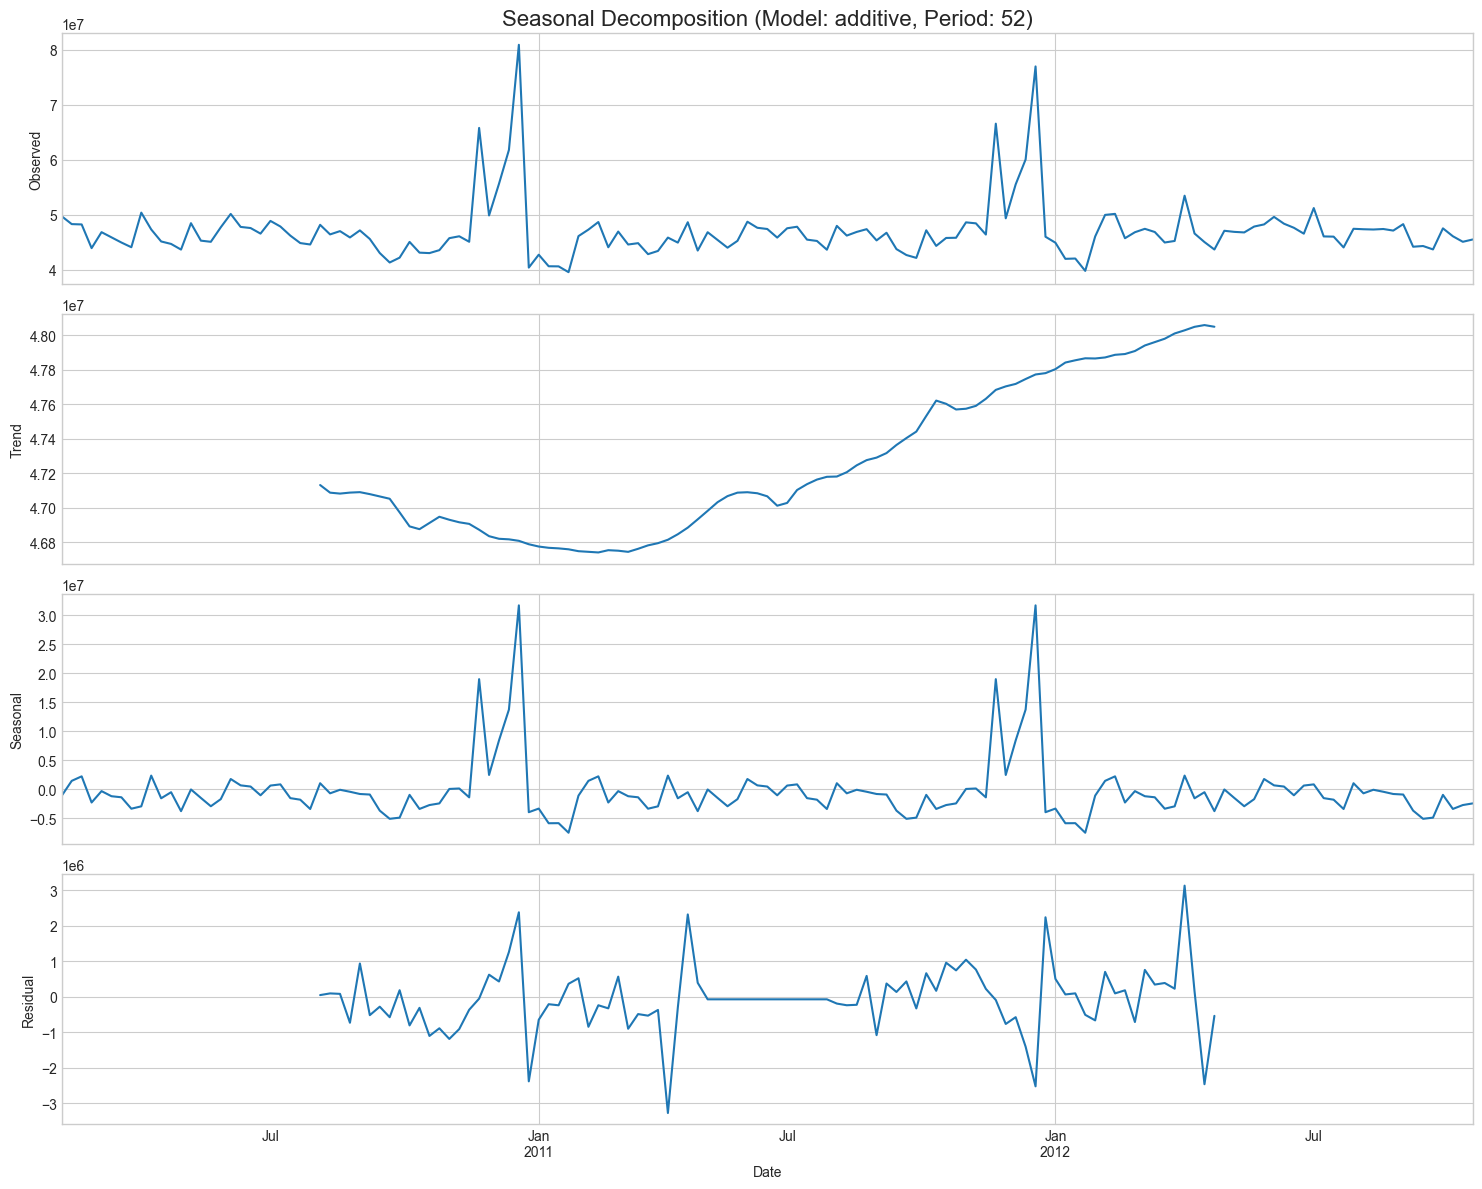

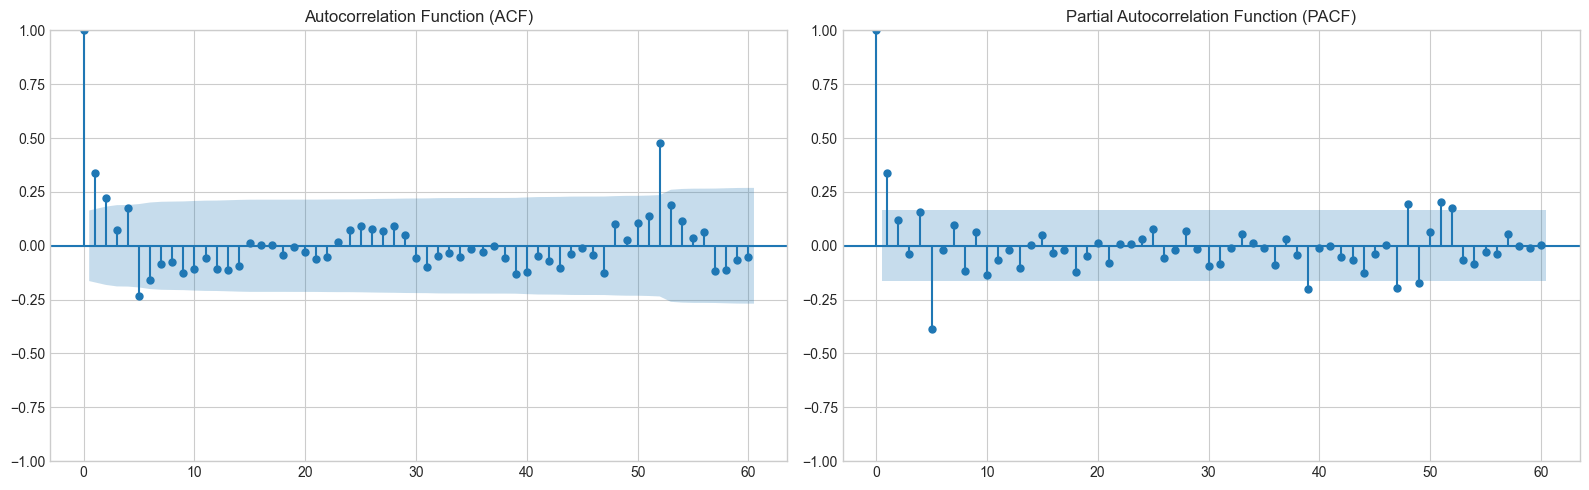

In [ ]:
if df is not None:
    print("\n--- Time Series EDA: Overall Weekly Sales ---")
    # Aggregate total sales by date
    overall_sales_ts = df.groupby('Date')['Weekly_Sales'].sum()

    # Plot overall sales time series
    plot_time_series(overall_sales_ts.reset_index(), 'Date', 'Weekly_Sales', 'Overall Total Weekly Sales')

    # Seasonal Decomposition for overall sales
    # Ensure the index is a DatetimeIndex and it's a Series
    overall_sales_series = overall_sales_ts.asfreq('W-FRI') 
    if isinstance(overall_sales_ts.index, pd.DatetimeIndex):
        plot_seasonal_decomposition(overall_sales_ts, period=52) # Assuming 52 weeks seasonality
        plot_acf_pacf(overall_sales_ts, lags=60) # Look at lags up to a bit more than a year
    else:
        print("Index of overall_sales_ts is not DatetimeIndex. Cannot perform decomposition/ACF/PACF directly.")

else:
    print("DataFrame 'df' is None. Skipping Overall Sales Time Series EDA.")


--- Time Series EDA: Specific Store-Department Combinations ---
Analyzing top selling combination: Store 14, Dept 92

--- Analyzing Store: 1, Department: 1 ---


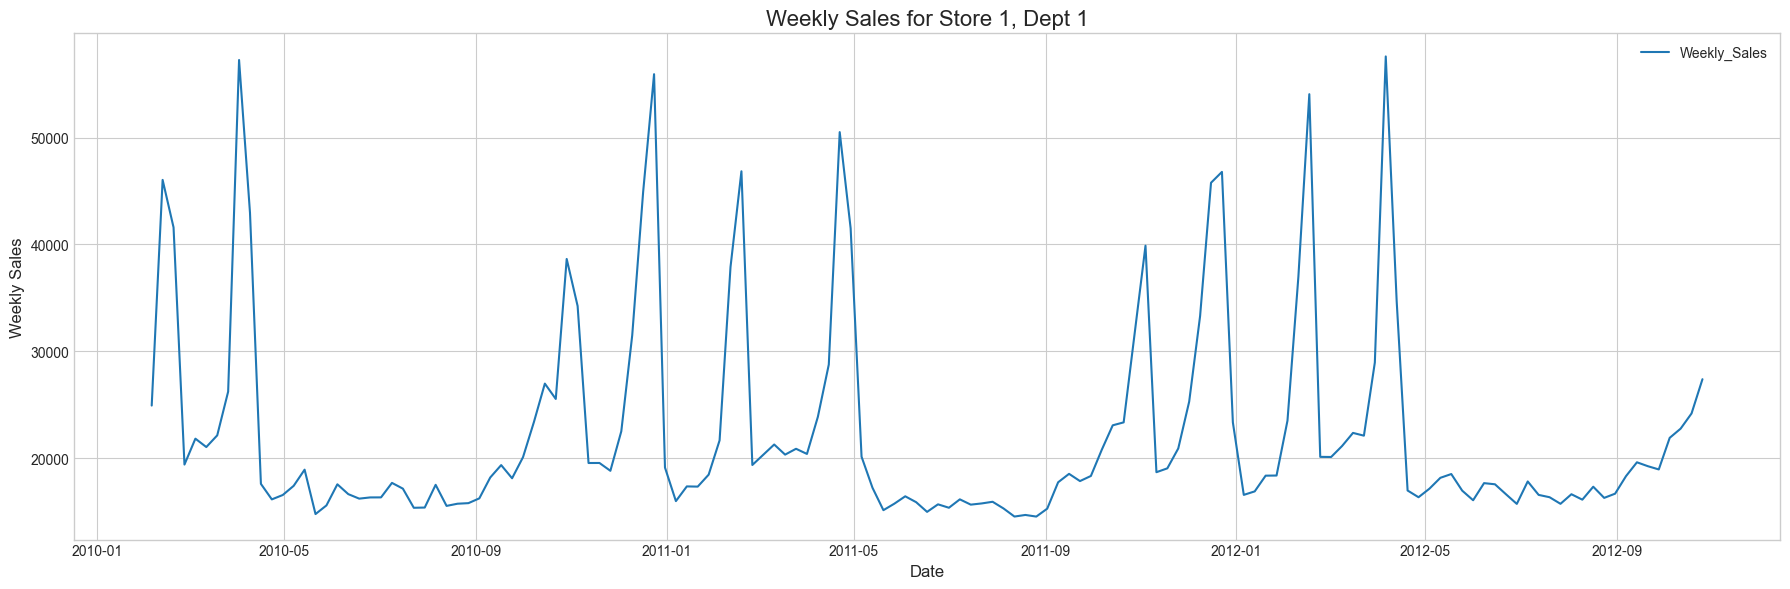

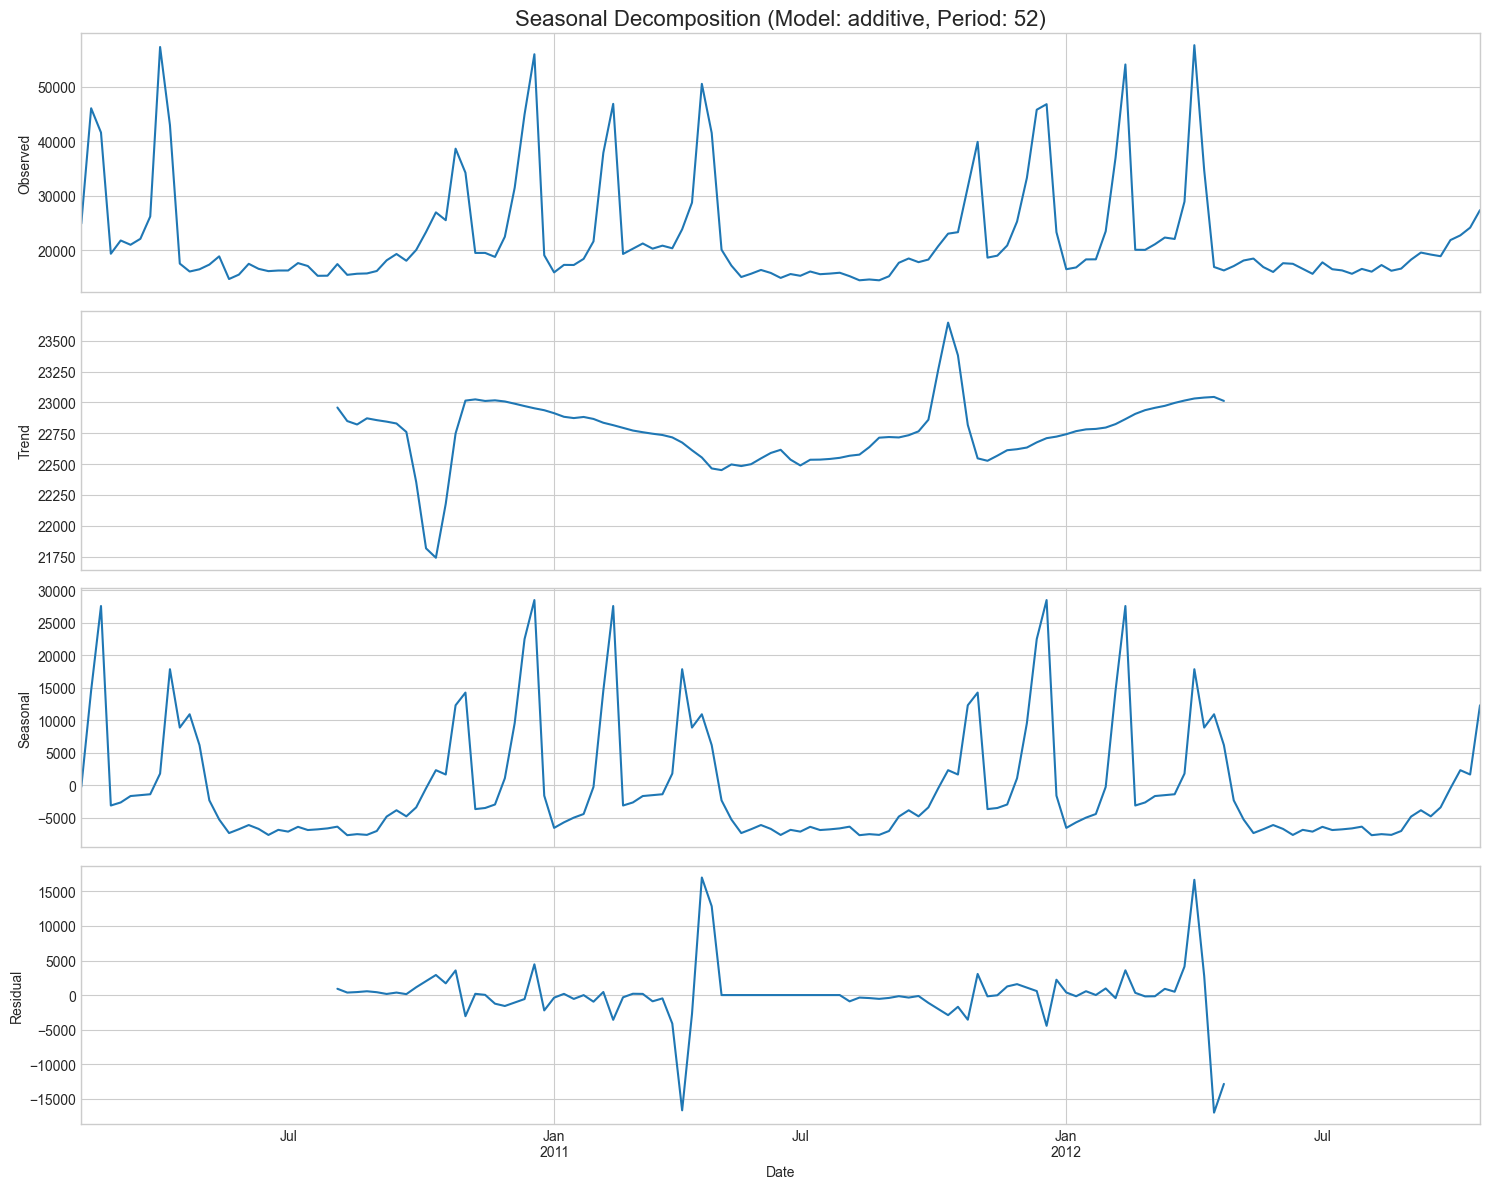

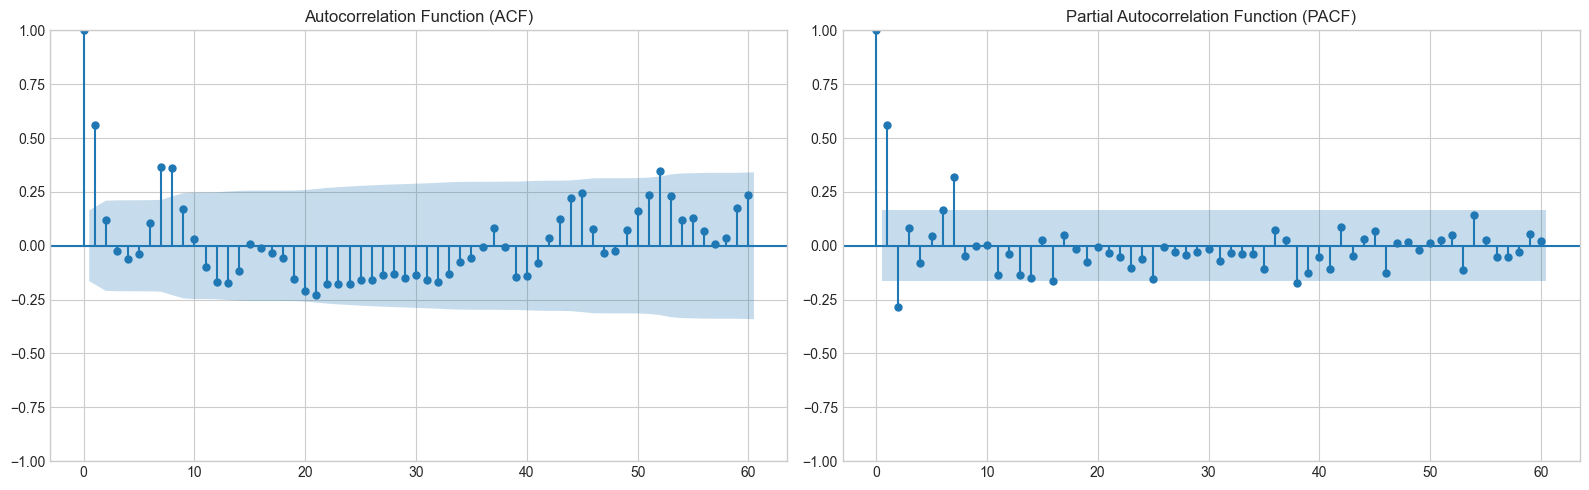


--- Analyzing Store: 4, Department: 1 ---


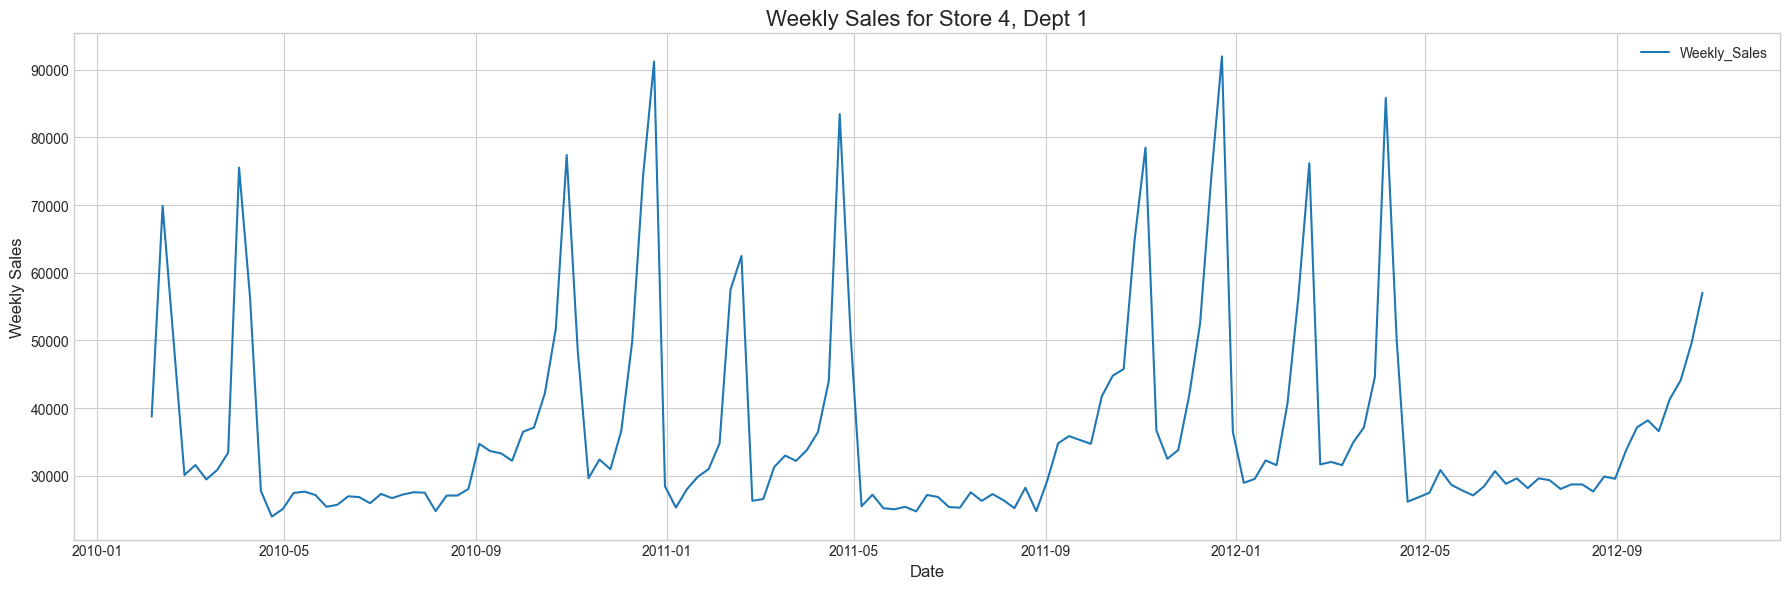

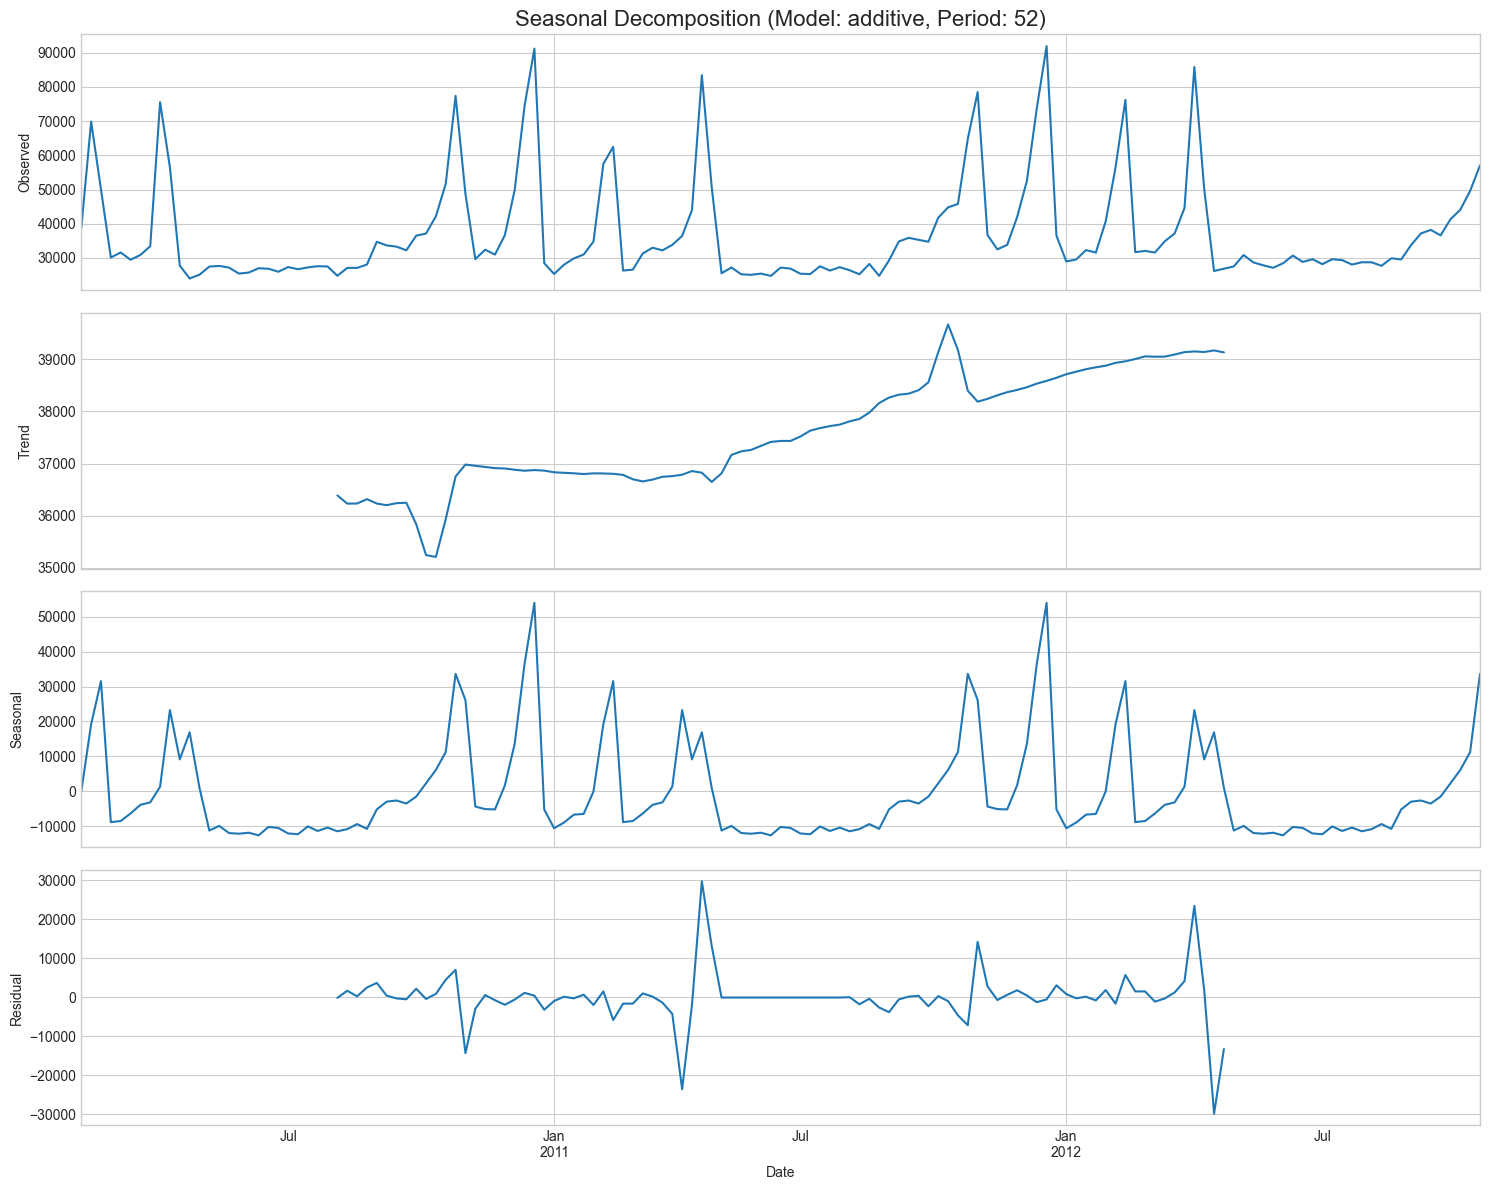

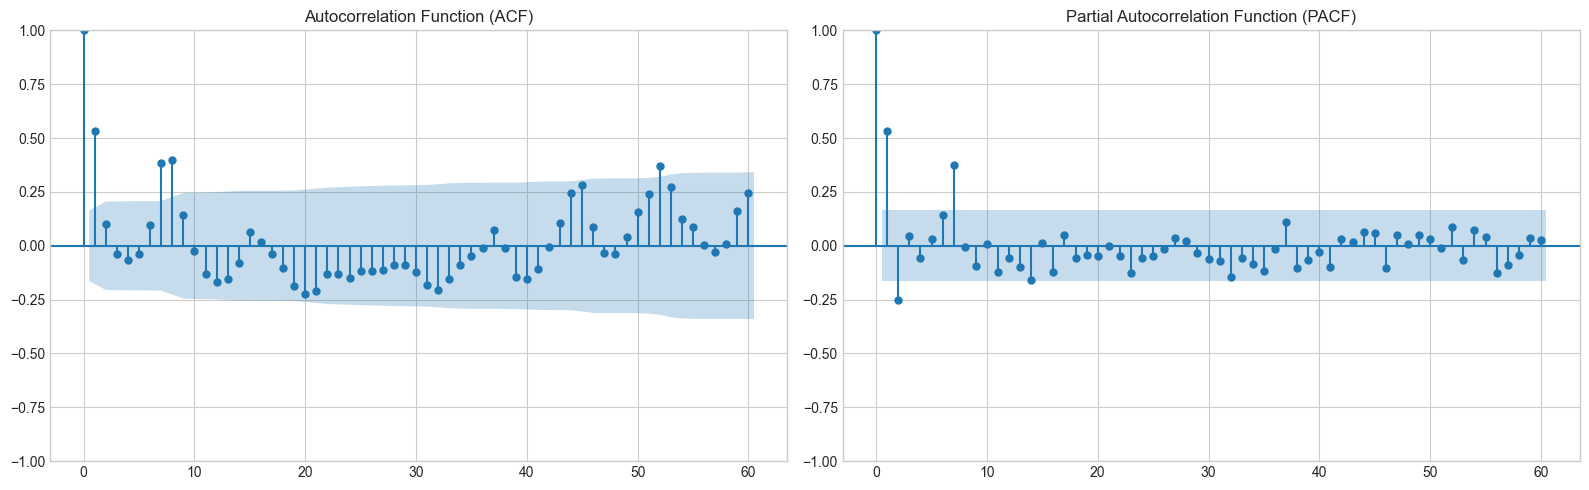


--- Analyzing Store: 10, Department: 72 ---


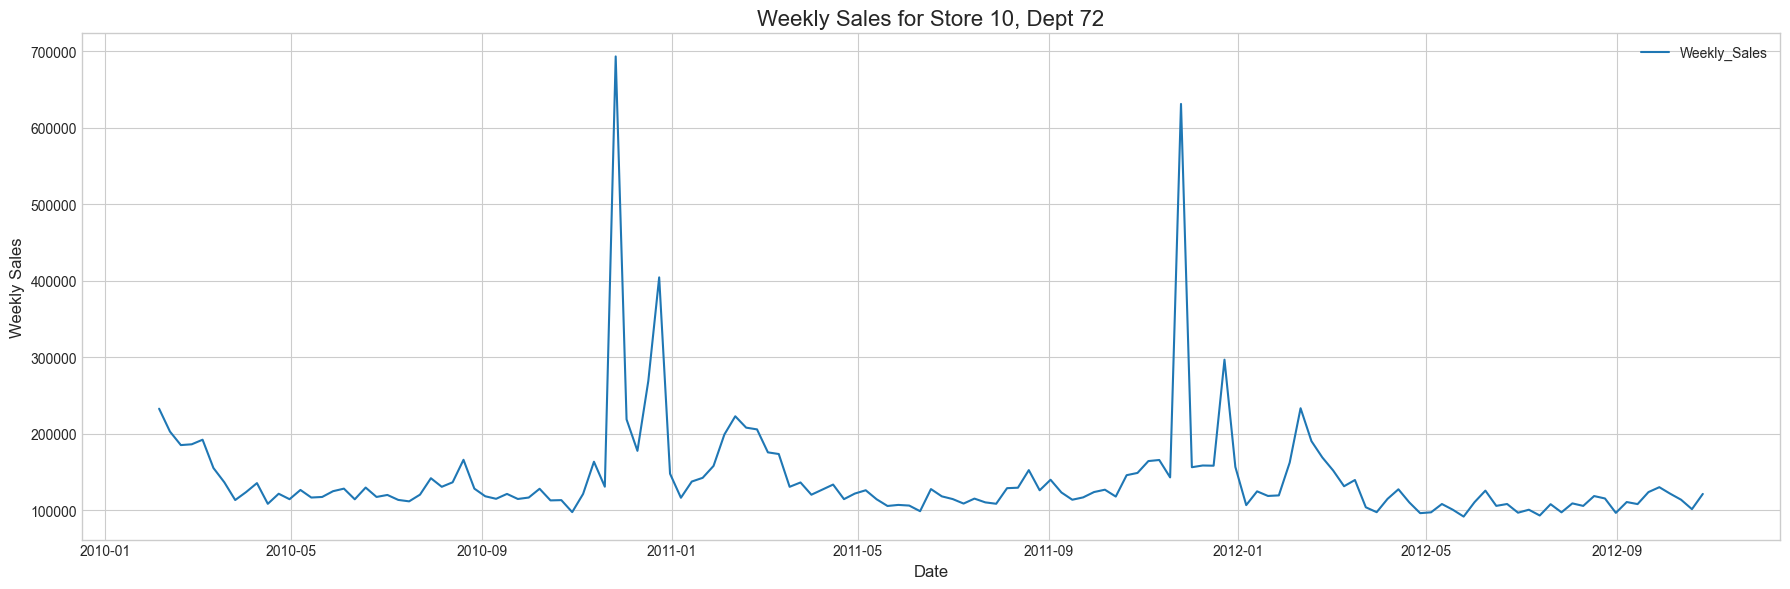

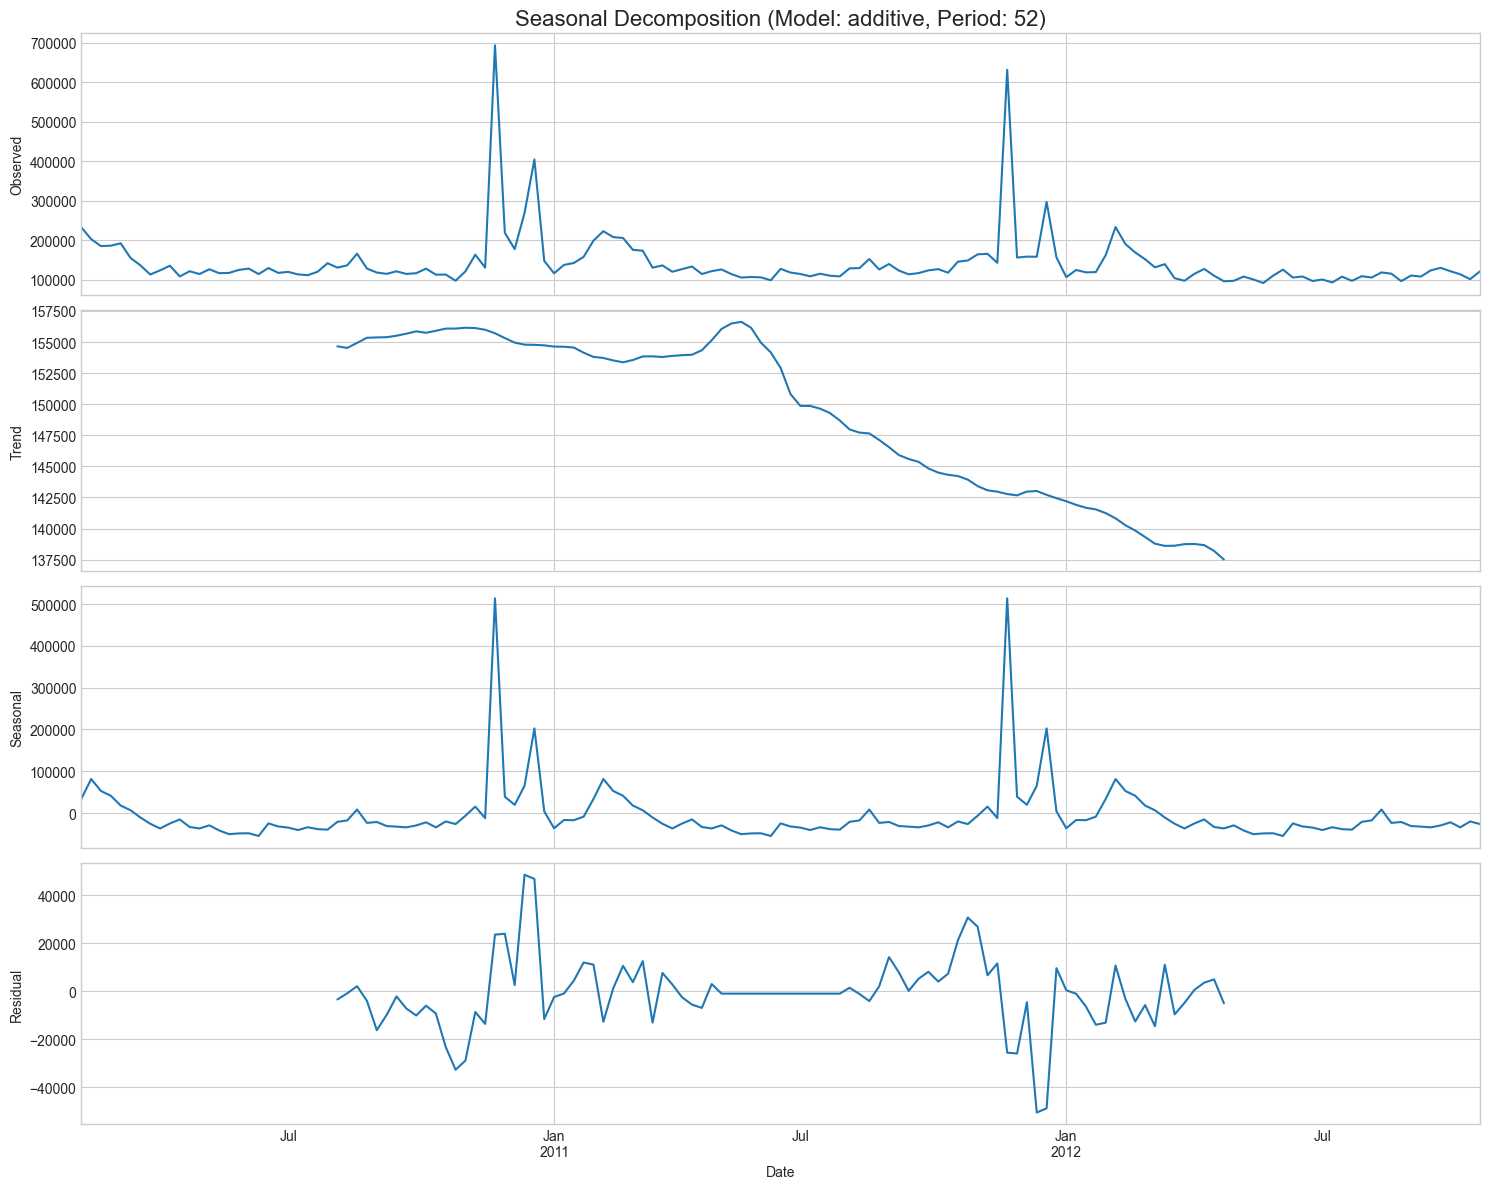

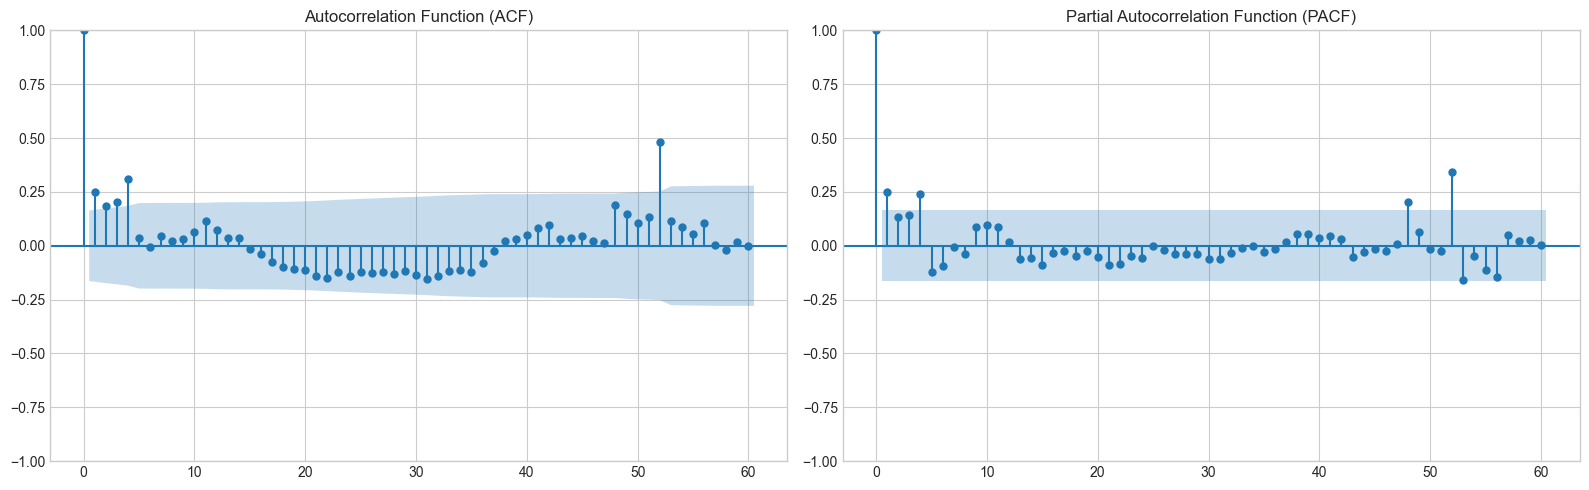


--- Analyzing Store: 14, Department: 92 ---


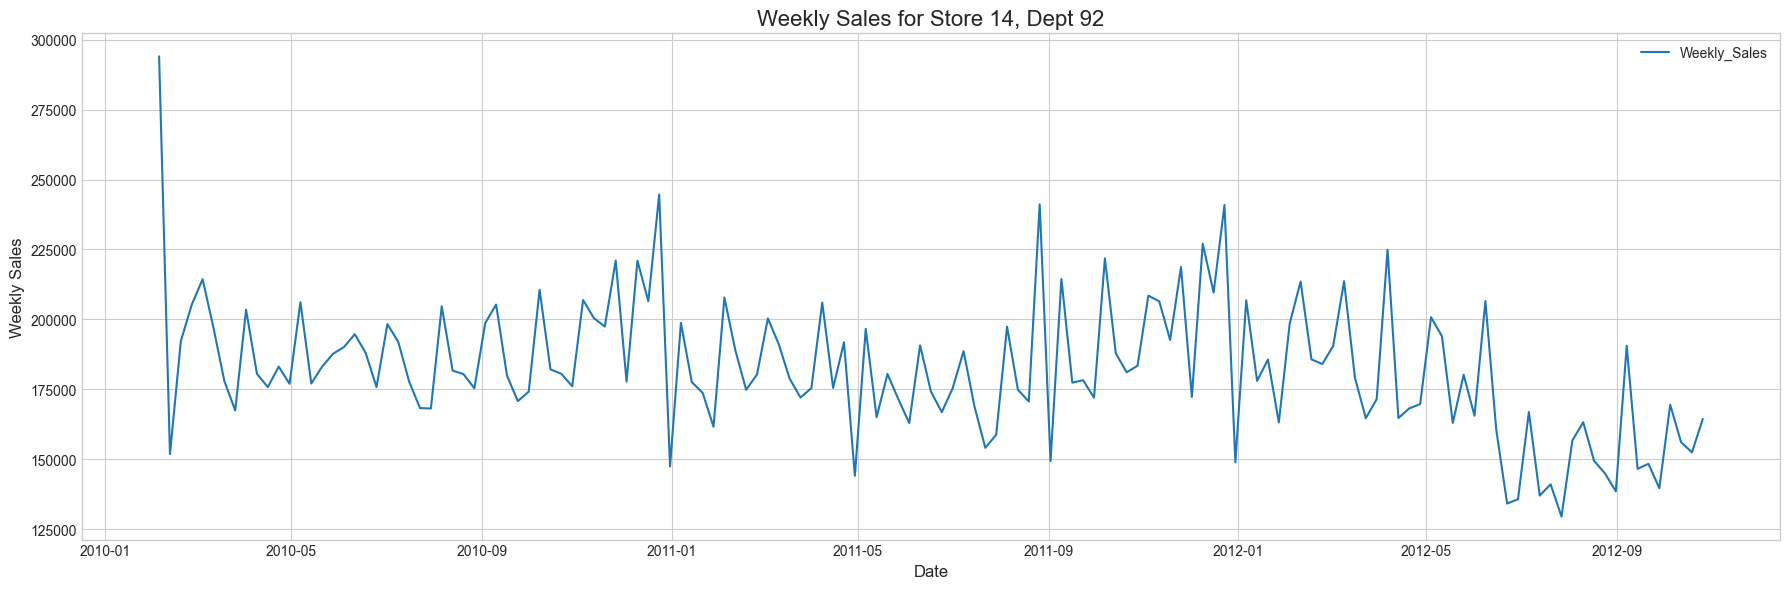

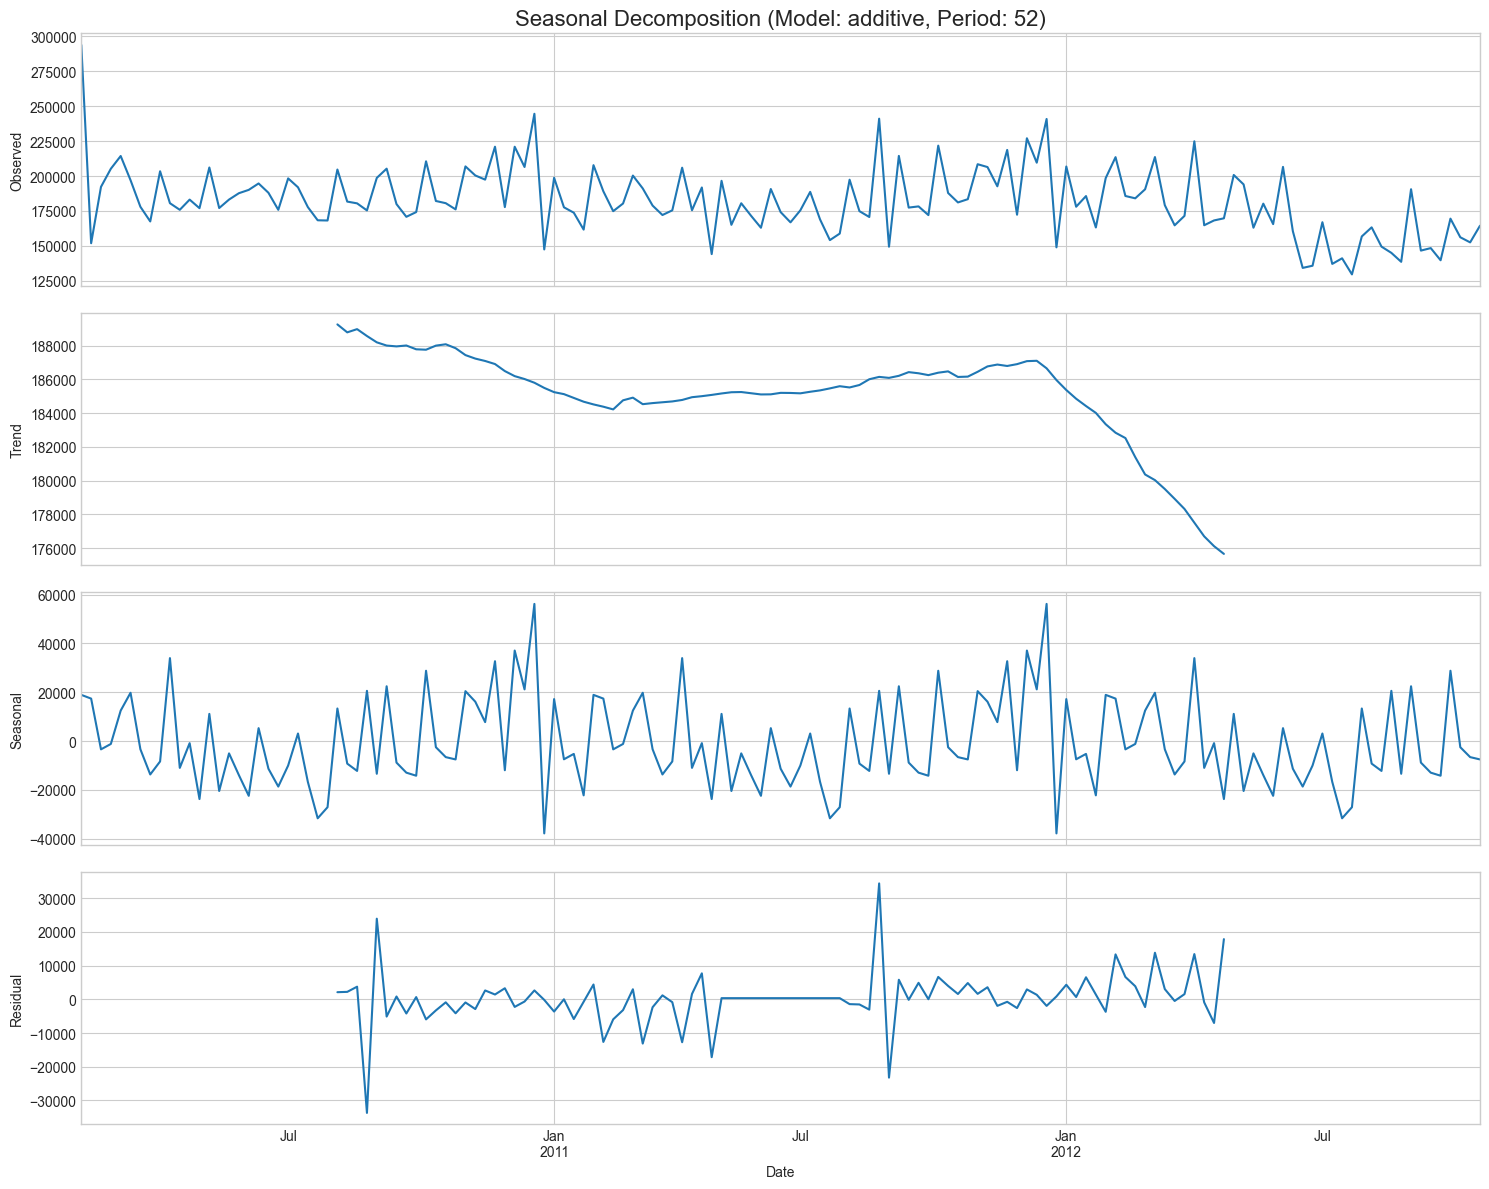

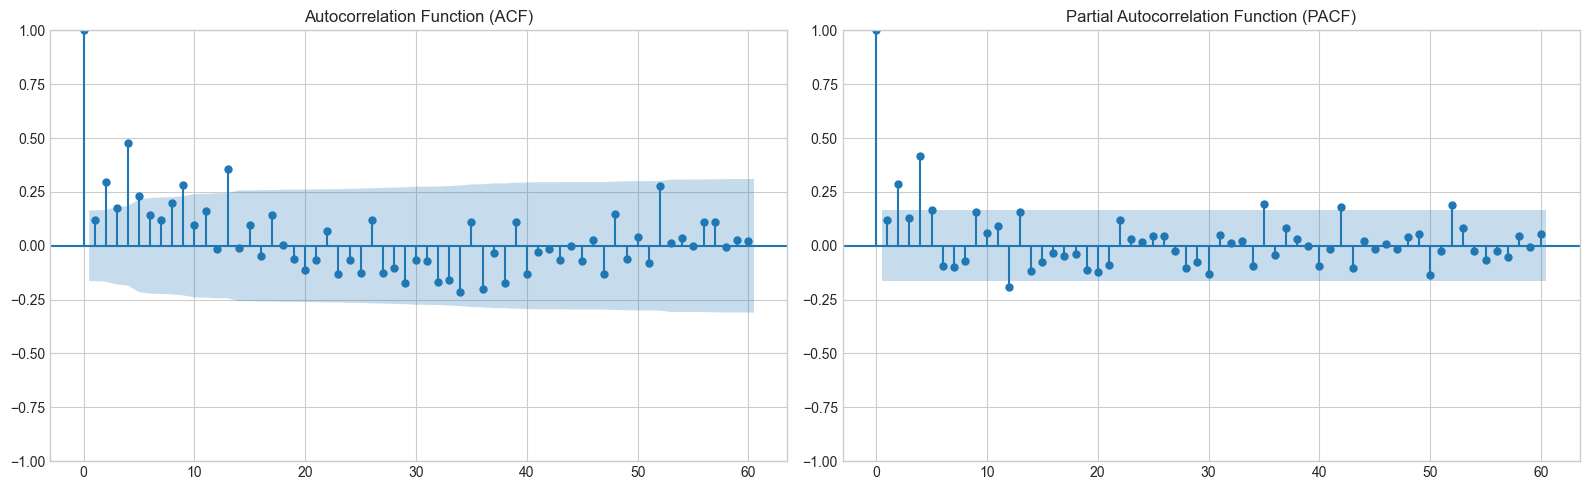

In [ ]:
if df is not None:
    print("\n--- Time Series EDA: Specific Store-Department Combinations ---")
    
    # Identify some interesting Store-Dept combinations for deeper analysis
    # Example: Top selling Store-Dept
    top_store_dept = df.groupby(['Store', 'Dept'])['Weekly_Sales'].sum().nlargest(1).index[0]
    print(f"Analyzing top selling combination: Store {top_store_dept[0]}, Dept {top_store_dept[1]}")
    
    store_dept_combinations_to_analyze = [
        top_store_dept,
        (1, 1), # Store 1, Dept 1
        (4, 1), # Store 4, Dept 1
        (10, 72) # Store 10, Dept 72
    ]
    # Remove duplicates if top_store_dept is one of the fixed ones
    store_dept_combinations_to_analyze = sorted(list(set(store_dept_combinations_to_analyze)))


    for store_id, dept_id in store_dept_combinations_to_analyze:
        print(f"\n--- Analyzing Store: {store_id}, Department: {dept_id} ---")
        
        # Filter data for the specific store and department
        store_dept_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)].copy()
        
        if store_dept_df.empty:
            print(f"No data found for Store {store_id}, Dept {dept_id}.")
            continue
            
        # Set Date as index for time series operations
        store_dept_ts = store_dept_df.set_index('Date')['Weekly_Sales']
        store_dept_ts_resampled = store_dept_ts.asfreq('W-FRI') 
        if store_dept_ts_resampled.isnull().any():
            print(f"Warning: Resampling for Store {store_id}, Dept {dept_id} introduced NaNs. Filling with 0 for decomposition.")
            store_dept_ts_resampled = store_dept_ts_resampled.fillna(0) # Simple fill, consider interpolation for better results

        plot_title = f'Weekly Sales for Store {store_id}, Dept {dept_id}'
        plot_time_series(store_dept_df, 'Date', 'Weekly_Sales', plot_title, ylabel='Weekly Sales')
        
        # Seasonal Decomposition
        if len(store_dept_ts_resampled) >= 2 * 52: # Need at least 2 full periods
            plot_seasonal_decomposition(store_dept_ts_resampled, period=52)
        else:
            print(f"Time series for Store {store_id}, Dept {dept_id} is too short for seasonal decomposition with period 52.")
            
        # ACF and PACF plots
        plot_acf_pacf(store_dept_ts, lags=60) # Use original series for ACF/PACF before resampling/filling for decomposition
else:
    print("DataFrame 'df' is None. Skipping Specific Store-Department Time Series EDA.")


--- Saving Processed DataFrame ---
Processed DataFrame saved successfully to: /Users/ramesh/Desktop/supply_chain_ai_platform/data/processed/walmart_data_cleaned.parquet


In [ ]:
import os

if 'df' in locals() and df is not None: # Check if df exists and is not None
    print("\n--- Saving Processed DataFrame ---")
    
    # Ensure project_root is defined (it should have been from Cell 1)
    if 'project_root' not in locals():
        # Attempt to define project_root if it's missing from the current cell's scope
        # This assumes your notebook is in 'notebooks/' and 'src/' is a sibling directory
        current_notebook_path = os.getcwd() # Should be .../MySupplyChainProject/notebooks
        project_root = os.path.abspath(os.path.join(current_notebook_path, '..'))
        print(f"Dynamically determined project_root: {project_root}")

    # Define the path to the processed data directory
    processed_data_dir = os.path.join(project_root, 'data', 'processed')
    
    # Create the directory if it doesn't exist
    os.makedirs(processed_data_dir, exist_ok=True)
    
    processed_file_path_parquet = os.path.join(processed_data_dir, 'walmart_data_cleaned.parquet')
    processed_file_path_csv = os.path.join(processed_data_dir, 'walmart_data_cleaned.csv') # Fallback path
    
    try:
        # Attempt to save as Parquet
        print(f"Attempting to save to Parquet: {processed_file_path_parquet}")
        df.to_parquet(processed_file_path_parquet, index=False)
        print(f"Processed DataFrame saved successfully to: {processed_file_path_parquet}")
    except ImportError:
        print("ImportError: `pyarrow` or `fastparquet` library not found for Parquet. Please install it (e.g., `pip install pyarrow`).")
        print(f"Attempting to save as CSV instead: {processed_file_path_csv}")
        try:
            df.to_csv(processed_file_path_csv, index=False)
            print(f"Processed DataFrame saved successfully as CSV to: {processed_file_path_csv}")
        except Exception as e_csv:
            print(f"Error saving DataFrame to CSV: {e_csv}")
    except Exception as e:
        print(f"Error saving DataFrame to Parquet: {e}")
        print(f"Attempting to save as CSV instead: {processed_file_path_csv}")
        try:
            df.to_csv(processed_file_path_csv, index=False)
            print(f"Processed DataFrame saved successfully as CSV to: {processed_file_path_csv}")
        except Exception as e_csv:
            print(f"Error saving DataFrame to CSV: {e_csv}")
else:
    print("DataFrame 'df' is not defined or is None. Nothing to save.")


--- Saving Processed DataFrame ---
Attempting to save to Parquet: /Users/ramesh/Desktop/supply_chain_ai_platform/data/processed/walmart_data_cleaned.parquet
Processed DataFrame saved successfully to: /Users/ramesh/Desktop/supply_chain_ai_platform/data/processed/walmart_data_cleaned.parquet
